## DSC 180AB Data Science Capstone
### Replication Project

Team Members:
- Edwin Tse
- Garrick Su
- Joseph Perez
- Maricela Vasquez 
- Qixi Huang

### Table of Contents
To return to the table of contents, click on the number at any major section heading.

[1. Introduction](#1.-Introduction)

[2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)

[3. Model Development](#3.-Model-Development)

[4. Model Evaluation](#4.-Model-Evaluation)

[5. Bias Mitigation](#5.-Bias-Mitigation)

[6. Results Summary](#6.-Results-Summary)

[7. Explainability](#7.-Explainability)

[8. Conclusion & Discussion](#8.-Conclusion-&-Discussion)

[9. Contributions](#9.-Contributions)


## This tutorial demonstrates classification model learning with bias mitigation as a part of a Care Management use case using Medical Expenditure data.

The notebook demonstrates how the AIF 360 toolkit can be used to detect and reduce bias when learning classifiers using a variety of fairness metrics and algorithms. It also demonstrates how explanations can be generated for predictions made by models learned with the toolkit using LIME.

* Classifiers are built using Logistic Regression as well as Random Forests.
* Bias detection is demonstrated using several metrics, including disparate impact, average odds difference, statistical parity difference, equal opportunity difference, and Theil index.
* Bias alleviation is explored via a variety of methods, including reweighing (pre-processing algorithm), prejudice remover (in-processing algorithm), and disparate impact remover (pre-processing technique).
* Data from the [Medical Expenditure Panel Survey](https://meps.ahrq.gov/mepsweb/) is used in this tutorial.


The Medical Expenditure Panel Survey (MEPS) provides nationally representative estimates of health expenditure, utilization, payment sources, health status, and health insurance coverage among the noninstitutionalized U.S. population. These government-produced data sets examine how people use the US healthcare system.

MEPS is administered by the Agency for Healthcare Research and Quality (AHRQ) and is divided into three components: 
* Household
* Insurance/Employer, and 
* Medical Provider. 

These components provide comprehensive national estimates of healthcare use and payment by individuals, families, and other demographic groups of interest.

### [1.](#Table-of-Contents) Introduction

The [AI Fairness 360 toolkit](https://github.com/Trusted-AI/AIF360) is an extensible open-source library containing techniques developed by the research community to help detect and mitigate bias in machine learning models throughout the AI application lifecycle. AI Fairness 360 package is available in both Python, and R. Documentation is available [here](https://aif360.readthedocs.io/en/v0.2.3/index.html)

The AI Fairness 360 package includes the following: 
- a comprehensive set of metrics for datasets and models to test for biases,
- explanations for these metrics, and
- algorithms to mitigate bias in datasets and models
It is designed to translate algorithmic research from the lab into the actual practice of domains as wide-ranging as finance, human capital management, healthcare, and education.

#### 1.1 Use Case

**In order to demonstrate how AIF360 can be used to detect and mitigate bias in classifier models, we adopt the following use case:**

* Data scientist develops a 'fair' healthcare utilization scoring model with respect to defined protected classes. Fairness may be dictated by legal or government regulations, such as a requirement that additional care decisions not be predicated on factors such as the race of the patient.
* Developer takes the model AND performance characteristics/specs of the model (e.g. accuracy, fairness tests, etc., basically the model factsheet) and deploys the model in an enterprise app that prioritizes cases for care management.
* The app is put into production and starts scoring people and making recommendations. 
* Explanations are generated for each recommendation
* Both recommendations and associated explanations are given to nurses as a part of the care management process. The nurses can evaluate the recommendations for quality and correctness and provide feedback.
* Nurse feedback, as well as analysis of usage data with respect to specs of the model w.r.t accuracy and fairness, is communicated to the AI Ops specialist and LOB user periodically.
* When significant drift in model specs relative to the model factsheet is observed, the model is returned for retraining.

#### 1.2 Data
Released as an ASCII file (with related SAS, SPSS, and STATA programming statements) and a SAS transport dataset, this public use file provides information collected on a nationally representative sample of the civilian noninstitutionalized population of the United States for the calendar year 2015. This file consists of MEPS survey data obtained in Rounds 3, 4, and 5 of Panel 19 and Rounds 1, 2, and 3 of Panel 20 (i.e., the rounds for the MEPS panels covering the calendar year 2015) and consolidates all of the final 2015 person-level variables onto one file. This file contains the following variables previously released on HC-174: survey administration, the language of interview variable, demographics, parent identifiers, health status, disability days variables, access to care, employment, quality of care, patient satisfaction, health insurance, and use variables. The HC-181 file also includes these variables: income variables and expenditure variables.

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models); one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of the updated model).

#### 1.3 Methodology 

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non-Hispanic); 'Non-Whites' that included everyone else.  

* Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as the history of diagnosis of cancer or diabetes), and limitations (such as cognitive or hearing or vision limitation).
* To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office-based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High-utilization respondents constituted around 17% of each dataset.
* To simulate the scenario, each dataset is split into three parts: a train, a validation, and a test/deployment part.

**We assume that the model is initially built and tuned using the 2015 Panel 19 train/test data**
* It is then put into practice and used to score people to identify potential candidates for care management. 
* Initial deployment is simulated to 2015 Panel 20 deployment data. 
* To show changes in performance and/or fairness over time, the 2016 Panel 21 deployment data is used. 
* Finally, if drift is observed, the 2015 train/validation data is used to learn a new model and evaluated again on the 2016 deployment data.

Medical resources are an essential right that people should have access to, and medical expenditure is important to manage because it may discourage people from getting medical help, but is also important to fairly charge people a manageable amount if they have high utilization. If prices are too high patients with chronic illnesses may feel depressed or that they are straining their families by simply living. 

The benefit of predicting utilization is that we can dedicate resources beforehand, which may lower costs and expenditures. It also allows insurance companies and medical institutions to plan accordingly to the patient's utilization.

If there were errors, patients might not get their needed treatment or have been on the wrong insurance plan. This would likely increase medical expenditure, or in the worse case, medical institutions might not be prepared for a patient.

The affected parties and stakeholders would be the patients, medical institutions, and insurance companies. It could even affect non-patients through the insurance plans they have regardless of whether they would want to go to a medical institution.

### [2.](#Table-of-Contents) Exploratory Data Analysis (EDA)


The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

* The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). 
* The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

In this example, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

See the corresponding [Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

##### Key MEPS dataset features include:
* **Utilization**: To measure utilization, a composite feature, 'UTILIZATION', was created to measure the total number of trips requiring some sort of medical care by summing up the following features: OBTOTV15(16), the number of office based visits;  OPTOTV15(16), the number of outpatient visits; ERTOT15(16), the number of ER visits;  IPNGTD15(16), the number of inpatient nights, and  + HHTOTD16, the number of home health visits.
* The model classification task is to predict whether a person would have **'high'** utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

#### 2.0 Pre-processing Scripts (for each Panel)

There is currently minimal EDA for this tutorial within IBM AIF360 Medical Expenditure Tutorial. Therefore, we have adapted  utility scripts from IBM AIF360 Tutorial for ease of understanding for how datasets were pre-processed. These will be used primarily for EDA purposes. We will utilize IBM's tutorial for the remainder of the project. We have utilized Pandas for this portion of the project. 

**Note:** these pre-processing script below are run for each data file, and then filtered for each panel. This was done in order to match subsequent portions of the tutorial, and how train/test/validation datasets were split.

#### 2.1 Get and Load Dataset, Apply Pre-processing

In [ ]:
import matplotlib.pyplot as plt

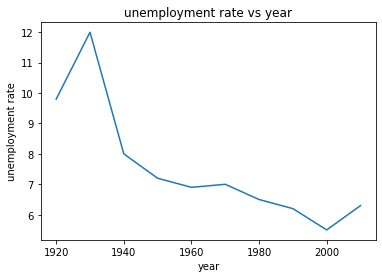

In [ ]:
year = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]
unemployment_rate = [9.8, 12, 8, 7.2, 6.9, 7, 6.5, 6.2, 5.5, 6.3]
plt.plot(year, unemployment_rate)
plt.title('unemployment rate vs year')
plt.xlabel('year')
plt.ylabel('unemployment rate')
plt.show()

In [ ]:
# To clone the repository:
!git clone https://github.com/Trusted-AI/AIF360.git
# Make sure after cloning it, you would put the .csv file to ./aif360/data/raw/meps/

Cloning into 'AIF360'...
remote: Enumerating objects: 3519, done.
remote: Counting objects: 100% (771/771), done.
remote: Compressing objects: 100% (276/276), done.
remote: Total 3519 (delta 584), reused 573 (delta 490), pack-reused 2748
Receiving objects: 100% (3519/3519), 7.03 MiB | 8.90 MiB/s, done.
Resolving deltas: 100% (2217/2217), done.


In [ ]:
! pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 3.9 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=cf251f4ca05912f588b568dc0a2a4e7d2dee7245d112b22ac0a51526dbff6f02
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [ ]:
! pip install aif360[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 214 kB 4.8 MB/s 
     |████████████████████████████████| 2.8 MB 41.3 MB/s 
     |████████████████████████████████| 510 kB 38.3 MB/s 
     |████████████████████████████████| 3.3 MB 44.5 MB/s 
     |████████████████████████████████| 1.4 MB 48.4 MB/s 
     |████████████████████████████████| 235 kB 56.9 MB/s 
     |████████████████████████████████| 2.6 MB 27.7 MB/s 
     |████████████████████████████████| 69 kB 3.6 MB/s 
     |████████████████████████████████| 9.4 MB 38.1 MB/s 
     |████████████████████████████████| 1.6 MB 44.9 MB/s 
     |████████████████████████████████| 295 kB 47.6 MB/s 
     |████████████████████████████████| 965 kB 51.7 MB/s 
     |████████████████████████████████| 121 kB 48.9 MB/s 
     |████████████████████████████████| 83 kB 1.9 MB/s 
     |████████████████████████████████| 575 kB 47.2 MB/s 
  Created wheel for BlackBoxAuditing

In [ ]:
# Imports
import sys

!pip install -U matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display
import pandas as pd
import seaborn as sns

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.pipeline import make_pipeline

from collections import defaultdict


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The code below allows adaptation to the Google Collab environment.
- True: Run in Collab
- False: Run in local runtime

In [ ]:
### remember to download the csv file then upload to the colab Files, which will be deleted each time it reconnected

if True: # Change True False for colab environment
  colab_path = "/content/AIF360/" #/aif360/data/raw/meps/h181.csv
else:
    colab_path = ".."

In [ ]:
# This cell would download the 2 dataset directly without any trouble, if running local environment
# ensure that you pip install gdown
import gdown
gdown.download("https://drive.google.com/uc?export=download&id=1YCJVsfkOxrUoaTRLfe59phWBIQO8mG3B",
               "./", quiet=False)
!unzip archive.zip

Downloading...
From: https://drive.google.com/uc?export=download&id=1YCJVsfkOxrUoaTRLfe59phWBIQO8mG3B
To: /content/archive.zip
100%|██████████| 23.0M/23.0M [00:00<00:00, 128MB/s]


Archive:  archive.zip
  inflating: h181.csv                
  inflating: h192.csv                


In [ ]:
!cp /content/h181.csv /content/AIF360/aif360/data/raw/meps/h181.csv

In [ ]:
raw_181 = pd.read_csv(colab_path +'aif360/data/raw/meps/h181.csv')

#### Apply pre-processing scripts

In [ ]:
default_mappings = {
    'label_maps': [{1.0: '>= 10 Visits', 0.0: '< 10 Visits'}],
    'protected_attribute_maps': [{1.0: 'White', 0.0: 'Non-White'}]}

def default_preprocessing19(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 19
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE#return 'White'
            return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})
    
    df = df[df['PANEL'] == 19]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

In [ ]:
def default_preprocessing20(df):
    """
    1.Create a new column, RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White
      and 'non-White' otherwise
    2. Restrict to Panel 20
    3. RENAME all columns that are PANEL/ROUND SPECIFIC
    4. Drop rows based on certain values of individual features that correspond to missing/unknown - generally < -1
    5. Compute UTILIZATION, binarize it to 0 (< 10) and 1 (>= 10)
    """
    def race(row):
        if ((row['HISPANX'] == 2) and (row['RACEV2X'] == 1)):  #non-Hispanic Whites are marked as WHITE; all others as NON-WHITE
            return 'White'
        return 'Non-White'

    df['RACEV2X'] = df.apply(lambda row: race(row), axis=1)
    df = df.rename(columns = {'RACEV2X' : 'RACE'})

    df = df[df['PANEL'] == 20]

    # RENAME COLUMNS
    df = df.rename(columns = {'FTSTU53X' : 'FTSTU', 'ACTDTY53' : 'ACTDTY', 'HONRDC53' : 'HONRDC', 'RTHLTH53' : 'RTHLTH',
                              'MNHLTH53' : 'MNHLTH', 'CHBRON53' : 'CHBRON', 'JTPAIN53' : 'JTPAIN', 'PREGNT53' : 'PREGNT',
                              'WLKLIM53' : 'WLKLIM', 'ACTLIM53' : 'ACTLIM', 'SOCLIM53' : 'SOCLIM', 'COGLIM53' : 'COGLIM',
                              'EMPST53' : 'EMPST', 'REGION53' : 'REGION', 'MARRY53X' : 'MARRY', 'AGE53X' : 'AGE',
                              'POVCAT15' : 'POVCAT', 'INSCOV15' : 'INSCOV'})

    df = df[df['REGION'] >= 0] # remove values -1
    df = df[df['AGE'] >= 0] # remove values -1

    df = df[df['MARRY'] >= 0] # remove values -1, -7, -8, -9

    df = df[df['ASTHDX'] >= 0] # remove values -1, -7, -8, -9

    df = df[(df[['FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX','EDUCYR','HIDEG',
                             'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                             'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                             'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                             'PHQ242','EMPST','POVCAT','INSCOV']] >= -1).all(1)]  #for all other categorical features, remove values < -1

    def utilization(row):
        return row['OBTOTV15'] + row['OPTOTV15'] + row['ERTOT15'] + row['IPNGTD15'] + row['HHTOTD15']

    df['TOTEXP15'] = df.apply(lambda row: utilization(row), axis=1)
    lessE = df['TOTEXP15'] < 10.0
    df.loc[lessE,'TOTEXP15'] = 0.0
    moreE = df['TOTEXP15'] >= 10.0
    df.loc[moreE,'TOTEXP15'] = 1.0

    df = df.rename(columns = {'TOTEXP15' : 'UTILIZATION'})
    return df

#### Taken from pre-processing scripts to retain same columns used in model development for tutorial

In [ ]:
label_name='UTILIZATION'
favorable_classes=[1.0]
protected_attribute_names=['RACE']
privileged_classes=[['White']]
instance_weights_name='PERWT15F'
categorical_features=['REGION','SEX','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42', 'PHQ242',
                                 'EMPST','POVCAT','INSCOV']

features_to_keep=['REGION','AGE','SEX','RACE','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42', 'ADSMOK42',
                                 'PCS42','MCS42','K6SUM42','PHQ242','EMPST','POVCAT','INSCOV','UTILIZATION', 'PERWT15F']
features_to_drop=[]
na_values=[]
# custom_preprocessing=default_preprocessing <- don't need this yet for EDA
metadata=default_mappings


We encourage you to search through the repository and take a look at these scripts, 
they can be found in `../aif360/dataset/` in your forked AIF360 repository:
* AIF360/aif360/datasets/meps_dataset_panel19_fy2015.py
* AIF360/aif360/datasets/meps_dataset_panel20_fy2015.py

To Explore the `Utilization` and `RACE` features, and the variables used to impute these features:
* See the corresponding [HC 181 Codebook](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) for information on variables.

In [ ]:
df_panel_19 = default_preprocessing19(raw_181)
df_panel_19_reduced = df_panel_19[features_to_keep]

In [ ]:
df_panel_20 = default_preprocessing20(raw_181)
df_panel_20_reduced = df_panel_20[features_to_keep]

In [ ]:
#### END OF PRE-PROCRESSING ####

#### 2.2 Data shape and features

In [ ]:
df_panel_19_reduced.head(5)

REGION  AGE  SEX       RACE  MARRY  FTSTU  ACTDTY  HONRDC  RTHLTH  MNHLTH  \
0       2   53    1  Non-White      5     -1       2       2       4       3   
1       2   56    2  Non-White      3     -1       2       2       4       3   
3       2   23    2  Non-White      5      3       2       2       1       1   
4       2    3    1  Non-White      6     -1       3       3       1       3   
5       3   27    1       None      1     -1       1       4       2       1   

   ...  ADSMOK42  PCS42  MCS42  K6SUM42  PHQ242  EMPST  POVCAT  INSCOV  \
0  ...         2  25.93  58.47        3       0      4       1       2   
1  ...         2  20.42  26.57       17       6      4       3       2   
3  ...         2  53.12  50.33        7       0      1       2       2   
4  ...        -1  -1.00  -1.00       -1      -1     -1       2       2   
5  ...        -1  -1.00  -1.00       -1      -1      1       3       1   

   UTILIZATION      PERWT15F  
0            1  21854.981705  
1            1  18169.604822  
3            0  17191.832515  
4            0  20261.485463  
5            0      0.000000  

[5 rows x 43 columns]

In [ ]:
df_panel_20_reduced.head(5)

REGION  AGE  SEX       RACE  MARRY  FTSTU  ACTDTY  HONRDC  RTHLTH  \
16578       3   65    1  Non-White      1     -1       4       1       3   
16579       3   57    2  Non-White      1     -1       2       2       3   
16580       4   40    1  Non-White      1     -1       2       2       3   
16581       3   55    2  Non-White      5     -1       2       2       3   
16582       3   21    2  Non-White      5      1       2       2       3   

       MNHLTH  ...  ADSMOK42  PCS42  MCS42  K6SUM42  PHQ242  EMPST  POVCAT  \
16578       3  ...         2  39.15  64.23        1       1      1       4   
16579       3  ...         2  23.61  48.28        5       3      4       4   
16580       3  ...         2  53.97  52.82        4       0      1       5   
16581       3  ...         1  40.50  61.61        0       0      1       2   
16582       3  ...        -1  -1.00  -1.00       -1      -1      4       2   

       INSCOV  UTILIZATION      PERWT15F  
16578       1            0  11966.862856  
16579       1            1  10300.188631  
16580       1            0  18749.279706  
16581       2            0   5532.628347  
16582       3            0      0.000000  

[5 rows x 43 columns]

In [ ]:
features_description = pd.read_html("https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_codebook.jsp?PUFId=H181")

In [ ]:
# Features description pulled from the website
description_df = features_description[7]
features_description[7].head()

Name  Start  End                               Description
0  ACCELI42    902  903  PERS ELIGIBLE FOR ACCESS SUPPLEMENT-R4/2
1  ACTDTY31    241  242     MILITARY FULL-TIME ACTIVE DUTY - R3/1
2  ACTDTY42    243  244     MILITARY FULL-TIME ACTIVE DUTY - R4/2
3  ACTDTY53    245  246     MILITARY FULL-TIME ACTIVE DUTY - R5/3
4  ACTLIM31    467  468  ANY LIMITATION WORK/HOUSEWRK/SCHL-RD 3/1

##### Identifying feature names


In [ ]:
descript_dict = dict(zip(description_df.Name.to_list(), description_df.Description.to_list()))

In [ ]:
df_panel_19_reduced.columns

Index(['REGION', 'AGE', 'SEX', 'RACE', 'MARRY', 'FTSTU', 'ACTDTY', 'HONRDC',
       'RTHLTH', 'MNHLTH', 'HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX',
       'STRKDX', 'EMPHDX', 'CHBRON', 'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN',
       'ARTHDX', 'ARTHTYPE', 'ASTHDX', 'ADHDADDX', 'PREGNT', 'WLKLIM',
       'ACTLIM', 'SOCLIM', 'COGLIM', 'DFHEAR42', 'DFSEE42', 'ADSMOK42',
       'PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'EMPST', 'POVCAT', 'INSCOV',
       'UTILIZATION', 'PERWT15F'],
      dtype='object')

Steps taken:

1.   Rename the columns to the meps orginal column names
2.   Map the column names with the description 



In [ ]:
descript_dict['REGION53']

'CENSUS REGION - R5/3'

In [ ]:
revert_dct = {'FTSTU': 'FTSTU53X',
 'ACTDTY': 'ACTDTY53',
 'HONRDC': 'HONRDC53',
 'RTHLTH': 'RTHLTH53',
 'MNHLTH': 'MNHLTH53',
 'CHBRON': 'CHBRON53',
 'JTPAIN': 'JTPAIN53',
 'PREGNT': 'PREGNT53',
 'WLKLIM': 'WLKLIM53',
 'ACTLIM': 'ACTLIM53',
 'SOCLIM': 'SOCLIM53',
 'COGLIM': 'COGLIM53',
 'EMPST': 'EMPST53',
 'REGION': 'REGION53',
 'MARRY': 'MARRY53X',
 'AGE': 'AGE53X',
 'POVCAT': 'POVCAT15',
 'INSCOV': 'INSCOV15'}

In [ ]:
list(map(descript_dict.get, list(map(lambda x: revert_dct.get(x) if revert_dct.get(x) != None else x, df_panel_19_reduced.columns))))

['CENSUS REGION - R5/3',
 'AGE - R5/3 (EDITED/IMPUTED)',
 'SEX',
 None,
 'MARITAL STATUS - R5/3 (EDITED/IMPUTED)',
 'STUDENT STATUS IF AGES 17-23 - R5/3',
 'MILITARY FULL-TIME ACTIVE DUTY - R5/3',
 'HONORABLY DISCHARGED FROM MILITARY',
 'PERCEIVED HEALTH STATUS - RD 5/3',
 'PERCEIVED MENTAL HEALTH STATUS - RD 5/3',
 'HIGH BLOOD PRESSURE DIAG (>17)',
 'CORONARY HRT DISEASE DIAG (>17)',
 'ANGINA DIAGNOSIS (>17)',
 'HEART ATTACK (MI) DIAG (>17)',
 'OTHER HEART DISEASE DIAG (>17)',
 'STROKE DIAGNOSIS (>17)',
 'EMPHYSEMA DIAGNOSIS (>17)',
 'CHRONC BRONCHITS LAST 12 MTHS (>17)-R5/3',
 'HIGH CHOLESTEROL DIAGNOSIS (>17)',
 'CANCER DIAGNOSIS (>17)',
 'DIABETES DIAGNOSIS (>17)',
 'JOINT PAIN LAST 12 MONTHS (>17) - RD 5/3',
 'ARTHRITIS DIAGNOSIS (>17)',
 'TYPE OF ARTHRITIS DIAGNOSED (>17)',
 'ASTHMA DIAGNOSIS',
 'ADHDADD DIAGNOSIS (5-17)',
 'PREGNANT DURING REF PERIOD - RD 5/3',
 'LIMITATION IN PHYSICAL FUNCTIONING-RD5/3',
 'ANY LIMITATION WORK/HOUSEWRK/SCHL-RD 5/3',
 'SOCIAL LIMITATIONS - RD 5/3

After eyeballing a bit on the orignal column name, the 2 descriptions that are missing are:

*   RACE (index = 3): 
 - In the function above RACE that is 'White' if RACEV2X = 1 and HISPANX = 2 i.e. non Hispanic White and 'non-White' otherwise
*   UTILIZATION (index = -2)
 - This column was renamed from TOTEXP15, the description is as follows: TOTAL HEALTH CARE EXP 15


##### Check for categorical features

Let's start by checking the column type of the dataframe

In [ ]:
df_panel_19_reduced.dtypes

REGION           int64
AGE              int64
SEX              int64
RACE            object
MARRY            int64
FTSTU            int64
ACTDTY           int64
HONRDC           int64
RTHLTH           int64
MNHLTH           int64
HIBPDX           int64
CHDDX            int64
ANGIDX           int64
MIDX             int64
OHRTDX           int64
STRKDX           int64
EMPHDX           int64
CHBRON           int64
CHOLDX           int64
CANCERDX         int64
DIABDX           int64
JTPAIN           int64
ARTHDX           int64
ARTHTYPE         int64
ASTHDX           int64
ADHDADDX         int64
PREGNT           int64
WLKLIM           int64
ACTLIM           int64
SOCLIM           int64
COGLIM           int64
DFHEAR42         int64
DFSEE42          int64
ADSMOK42         int64
PCS42          float64
MCS42          float64
K6SUM42          int64
PHQ242           int64
EMPST            int64
POVCAT           int64
INSCOV           int64
UTILIZATION      int64
PERWT15F       float64
dtype: obje

We could see clearly that RACE is a categorical features.
There is a chance that the numeric column may include categorical information, let's look into that.

In [ ]:
pd.concat([df_panel_19_reduced, df_panel_20_reduced]).nunique()

REGION             4
AGE               86
SEX                2
RACE               1
MARRY             10
FTSTU              4
ACTDTY             4
HONRDC             4
RTHLTH             6
MNHLTH             6
HIBPDX             3
CHDDX              3
ANGIDX             3
MIDX               3
OHRTDX             3
STRKDX             3
EMPHDX             3
CHBRON             3
CHOLDX             3
CANCERDX           3
DIABDX             3
JTPAIN             3
ARTHDX             3
ARTHTYPE           4
ASTHDX             2
ADHDADDX           3
PREGNT             3
WLKLIM             3
ACTLIM             3
SOCLIM             3
COGLIM             3
DFHEAR42           3
DFSEE42            3
ADSMOK42           3
PCS42           3817
MCS42           3753
K6SUM42           27
PHQ242             8
EMPST              5
POVCAT             5
INSCOV             3
UTILIZATION        2
PERWT15F       31592
dtype: int64

From the 2 results shown above, there only a few columns that are scalar variable, this includes:


*   AGE
*   PCS42: (SAQ:PHY COMPONENT SUMMRY SF-12V2 IMPUTED)
  - Google: SF-12v2 Physical Health Summary Scores
*   MCS42: (SAQ:MNT COMPONENT SUMMRY SF-12V2 IMPUTED)
  - Google: SF-12v2 Mental Health Summary Scores
*   PERWT15F: (FINAL PERSON WEIGHT, 2015)

Other columns are all categorical variables

##### Summary Statistics

In [ ]:
des_con = pd.concat([df_panel_19_reduced, df_panel_20_reduced]).describe()
des_con

REGION           AGE           SEX         MARRY         FTSTU  \
count  33400.000000  33400.000000  33400.000000  33400.000000  33400.000000   
mean       2.800659     35.251287      1.520269      3.642695     -0.719341   
std        1.009859     22.574061      0.499596      2.135461      0.909167   
min        1.000000      0.000000      1.000000      1.000000     -1.000000   
25%        2.000000     15.000000      1.000000      1.000000     -1.000000   
50%        3.000000     33.000000      2.000000      5.000000     -1.000000   
75%        4.000000     53.000000      2.000000      6.000000     -1.000000   
max        4.000000     85.000000      2.000000     10.000000      3.000000   

             ACTDTY        HONRDC        RTHLTH        MNHLTH        HIBPDX  \
count  33400.000000  33400.000000  33400.000000  33400.000000  33400.000000   
mean       2.588413      2.224281      2.176946      1.966707      0.920449   
std        0.763531      0.515658      1.070556      1.008230      1.267999   
min        1.000000      1.000000     -1.000000     -1.000000     -1.000000   
25%        2.000000      2.000000      1.000000      1.000000     -1.000000   
50%        2.000000      2.000000      2.000000      2.000000      1.000000   
75%        3.000000      3.000000      3.000000      3.000000      2.000000   
max        4.000000      4.000000      5.000000      5.000000      2.000000   

       ...      ADSMOK42         PCS42         MCS42       K6SUM42  \
count  ...  33400.000000  33400.000000  33400.000000  33400.000000   
mean   ...      0.736018     29.490556     31.021438      1.297305   
std    ...      1.417422     25.966822     26.932649      3.953697   
min    ...     -1.000000     -9.000000     -9.000000     -9.000000   
25%    ...     -1.000000     -1.000000     -1.000000     -1.000000   
50%    ...      2.000000     39.675000     42.700000      0.000000   
75%    ...      2.000000     54.800000     56.612500      2.000000   
max    ...      2.000000     72.070000     75.510000     24.000000   

             PHQ242         EMPST        POVCAT        INSCOV   UTILIZATION  \
count  33400.000000  33400.000000  33400.000000  33400.000000  33400.000000   
mean       0.006467      1.372275      3.304970      1.576946      0.171916   
std        1.282940      1.851044      1.482854      0.687282      0.377313   
min       -1.000000     -1.000000      1.000000      1.000000      0.000000   
25%       -1.000000     -1.000000      2.000000      1.000000      0.000000   
50%        0.000000      1.000000      4.000000      1.000000      0.000000   
75%        0.000000      4.000000      5.000000      2.000000      0.000000   
max        6.000000      4.000000      5.000000      3.000000      1.000000   

           PERWT15F  
count  33400.000000  
mean    9136.674818  
std     8318.681189  
min        0.000000  
25%     3624.410169  
50%     6627.638543  
75%    12065.846856  
max    98103.984953  

[8 rows x 42 columns]

Since the model focuses on finding the high utilization rate, lets check on some of summary statistic of the group

In [ ]:
concat_df = pd.concat([df_panel_19_reduced, df_panel_20_reduced])

In [ ]:
concat_df["UTILIZATION"].value_counts()

0    27658
1     5742
Name: UTILIZATION, dtype: int64

We could see that when the varible "UTILIZATION" == 1, are the high utilization rate group

In [ ]:
des_con_1 = concat_df[concat_df["UTILIZATION"] == 1].describe()
des_con_1

REGION          AGE          SEX        MARRY        FTSTU  \
count  5742.000000  5742.000000  5742.000000  5742.000000  5742.000000   
mean      2.660745    51.366945     1.625392     2.741205    -0.883838   
std       1.052293    22.250626     0.484064     1.906883     0.613601   
min       1.000000     0.000000     1.000000     1.000000    -1.000000   
25%       2.000000    35.000000     1.000000     1.000000    -1.000000   
50%       3.000000    55.000000     2.000000     2.000000    -1.000000   
75%       4.000000    68.000000     2.000000     5.000000    -1.000000   
max       4.000000    85.000000     2.000000    10.000000     3.000000   

            ACTDTY       HONRDC       RTHLTH       MNHLTH       HIBPDX  ...  \
count  5742.000000  5742.000000  5742.000000  5742.000000  5742.000000  ...   
mean      2.916405     2.000871     2.796412     2.400557     1.207419  ...   
std       0.953169     0.444243     1.194177     1.158470     0.886717  ...   
min       1.000000     1.000000    -1.000000    -1.000000    -1.000000  ...   
25%       2.000000     2.000000     2.000000     1.000000     1.000000  ...   
50%       3.000000     2.000000     3.000000     2.000000     1.000000  ...   
75%       4.000000     2.000000     4.000000     3.000000     2.000000  ...   
max       4.000000     4.000000     5.000000     5.000000     2.000000  ...   

          ADSMOK42        PCS42        MCS42      K6SUM42       PHQ242  \
count  5742.000000  5742.000000  5742.000000  5742.000000  5742.000000   
mean      1.363288    34.129272    39.877887     3.342564     0.740334   
std       1.132579    20.108995    21.743258     5.390437     1.673062   
min      -1.000000    -9.000000    -9.000000    -9.000000    -1.000000   
25%       1.000000    22.617500    30.922500     0.000000     0.000000   
50%       2.000000    38.655000    47.620000     2.000000     0.000000   
75%       2.000000    51.137500    56.670000     6.000000     2.000000   
max       2.000000    68.720000    74.980000    24.000000     6.000000   

             EMPST       POVCAT       INSCOV  UTILIZATION      PERWT15F  
count  5742.000000  5742.000000  5742.000000       5742.0   5742.000000  
mean      2.467955     3.464821     1.458029          1.0  11034.823275  
std       1.748695     1.493083     0.548531          0.0   8441.274443  
min      -1.000000     1.000000     1.000000          1.0      0.000000  
25%       1.000000     2.000000     1.000000          1.0   4799.596953  
50%       4.000000     4.000000     1.000000          1.0   9192.420012  
75%       4.000000     5.000000     2.000000          1.0  14903.249583  
max       4.000000     5.000000     3.000000          1.0  84381.577372  

[8 rows x 42 columns]

Some of the immediate notcieable difference is the mean difference betweeen the 2 sets

In [ ]:
des_con_1.loc["mean"] - concat_df[concat_df["UTILIZATION"] == 0].describe().loc["mean"] 

REGION           -0.168960
AGE              19.461385
SEX               0.126947
MARRY            -1.088645
FTSTU            -0.198648
ACTDTY            0.396086
HONRDC           -0.269792
RTHLTH            0.748072
MNHLTH            0.523921
HIBPDX            0.346547
CHDDX             0.551234
ANGIDX            0.605982
MIDX              0.584201
OHRTDX            0.491299
STRKDX            0.579825
EMPHDX            0.614745
CHBRON            0.594889
CHOLDX            0.366953
CANCERDX          0.498368
DIABDX            0.508316
JTPAIN            0.282420
ARTHDX            0.296999
ARTHTYPE          1.151996
ASTHDX           -0.078546
ADHDADDX         -0.557418
PREGNT           -0.080890
WLKLIM           -0.295284
ACTLIM           -0.113136
SOCLIM           -0.159214
COGLIM            0.499922
DFHEAR42         -0.034690
DFSEE42          -0.002453
ADSMOK42          0.757496
PCS42             5.601747
MCS42            10.695112
K6SUM42           2.469869
PHQ242            0.886223
E

This shows that the features selected are able to show the some of the differences betweem the 2 groups.

##### Shapes

In [ ]:
pd.concat([df_panel_19_reduced, df_panel_20_reduced]).shape


(33400, 43)

#### 2.3 Outlier Detection and Handling

In [ ]:
from scipy.stats import zscore
null_handled_concat = concat_df
zscores = concat_df.loc[:, null_handled_concat.columns !=
                                  'RACE'].apply(zscore)
zscores

REGION       AGE       SEX     MARRY     FTSTU    ACTDTY    HONRDC  \
0     -0.792854  0.786255 -1.041395  0.635612 -0.308703 -0.770659 -0.434949   
1     -0.792854  0.919153  0.960250 -0.300967 -0.308703 -0.770659 -0.434949   
3     -0.792854 -0.542723  0.960250  0.635612  4.090994 -0.770659 -0.434949   
4     -0.792854 -1.428709 -1.041395  1.103902 -0.308703  0.539065  1.504349   
5      0.197398 -0.365526 -1.041395 -1.237547 -0.308703 -2.080384  3.443647   
...         ...       ...       ...       ...       ...       ...       ...   
35422  0.197398 -1.207213 -1.041395  1.103902 -0.308703  0.539065  1.504349   
35423 -0.792854 -0.232628  0.960250  0.635612 -0.308703 -0.770659 -0.434949   
35424  0.197398 -0.144030 -1.041395 -1.237547 -0.308703 -0.770659 -0.434949   
35425  0.197398 -0.144030  0.960250 -1.237547 -0.308703 -0.770659 -0.434949   
35426  0.197398 -1.384410 -1.041395  1.103902 -0.308703  0.539065  1.504349   

         RTHLTH    MNHLTH    HIBPDX  ...  ADSMOK42     PCS42     MCS42  \
0      1.702930  1.024875  0.062738  ...  0.891760 -0.137121  1.019171   
1      1.702930  1.024875  0.062738  ...  0.891760 -0.349319 -0.165283   
3     -1.099395 -0.958830  0.851394  ...  0.891760  0.910000  0.716931   
4     -1.099395  1.024875 -1.514574  ... -1.224789 -1.174230 -1.188963   
5     -0.165287 -0.958830  0.851394  ... -1.224789 -1.174230 -1.188963   
...         ...       ...       ...  ...       ...       ...       ...   
35422 -1.099395 -0.958830 -1.514574  ... -1.224789 -1.174230 -1.188963   
35423  0.768821  0.033022  0.062738  ...  0.891760  0.571101 -0.096963   
35424  0.768821  0.033022  0.851394  ...  0.891760  0.281496  1.121650   
35425 -0.165287  0.033022  0.851394  ...  0.891760  1.039397  0.621878   
35426 -0.165287  0.033022 -1.514574  ... -1.224789 -1.174230 -1.188963   

        K6SUM42    PHQ242     EMPST    POVCAT    INSCOV  UTILIZATION  PERWT15F  
0      0.430665 -0.005041  1.419612 -1.554438  0.615555     2.194718  1.528908  
1      3.971708  4.671786  1.419612 -0.205667  0.615555     2.194718  1.085877  
3      1.442392 -0.005041 -0.201119 -0.880053  0.615555    -0.455639  0.968336  
4     -0.581061 -0.784512 -1.281607 -0.880053  0.615555    -0.455639  1.337349  
5     -0.581061 -0.784512 -0.201119 -0.205667 -0.839473    -0.455639 -1.098349  
...         ...       ...       ...       ...       ...          ...       ...  
35422 -0.581061 -0.784512 -1.281607 -1.554438  0.615555    -0.455639 -0.760308  
35423  1.442392  1.553902 -0.201119 -0.205667 -0.839473     2.194718  0.281878  
35424 -0.075198 -0.005041 -0.201119  1.143103 -0.839473    -0.455639 -0.093682  
35425 -0.075198 -0.005041 -0.201119  1.143103 -0.839473    -0.455639 -0.089868  
35426 -0.581061 -0.784512 -1.281607  1.143103 -0.839473    -0.455639 -0.200184  

[33400 rows x 42 columns]

To find the outliers we can find the zscores where the valeus exceed 3 standard deviations of the mean. We also remove the race column temporarily since it contains qualitative variables.

In [ ]:
outlier = (zscores < -3) | (zscores > 3)
outlier.sum()

REGION            0
AGE               0
SEX               0
MARRY             0
FTSTU          1335
ACTDTY            0
HONRDC           35
RTHLTH            0
MNHLTH          421
HIBPDX            0
CHDDX             0
ANGIDX            0
MIDX              0
OHRTDX            0
STRKDX            0
EMPHDX            0
CHBRON            0
CHOLDX            0
CANCERDX          0
DIABDX            0
JTPAIN            0
ARTHDX            0
ARTHTYPE          0
ASTHDX         3307
ADHDADDX          0
PREGNT            0
WLKLIM           72
ACTLIM         2372
SOCLIM         1531
COGLIM            0
DFHEAR42        792
DFSEE42         792
ADSMOK42          0
PCS42             0
MCS42             0
K6SUM42         731
PHQ242         1102
EMPST             0
POVCAT            0
INSCOV            0
UTILIZATION       0
PERWT15F        603
dtype: int64

There are outliers in 12 columns.

In [ ]:
concat_df.isna().sum()

REGION             0
AGE                0
SEX                0
RACE           10174
MARRY              0
FTSTU              0
ACTDTY             0
HONRDC             0
RTHLTH             0
MNHLTH             0
HIBPDX             0
CHDDX              0
ANGIDX             0
MIDX               0
OHRTDX             0
STRKDX             0
EMPHDX             0
CHBRON             0
CHOLDX             0
CANCERDX           0
DIABDX             0
JTPAIN             0
ARTHDX             0
ARTHTYPE           0
ASTHDX             0
ADHDADDX           0
PREGNT             0
WLKLIM             0
ACTLIM             0
SOCLIM             0
COGLIM             0
DFHEAR42           0
DFSEE42            0
ADSMOK42           0
PCS42              0
MCS42              0
K6SUM42            0
PHQ242             0
EMPST              0
POVCAT             0
INSCOV             0
UTILIZATION        0
PERWT15F           0
dtype: int64

There are only missing values in "RACE," which is our protected attribute, so it would be inappropriate to attempt any type of imputation as it may heavily affect our results while not representing reality of medical expenditures.

#### 2.4 Correlation Analysis

From above:
> The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

So our correlation analysis would focus on correlation with different features and high utitlization values.





In [ ]:
corr_df = concat_df.corr()

In [ ]:
corr_df[corr_df != 1].idxmax()

REGION           ASTHDX
AGE              EMPHDX
SEX              PREGNT
MARRY            HONRDC
FTSTU            PREGNT
ACTDTY              AGE
HONRDC         ADHDADDX
RTHLTH           MNHLTH
MNHLTH           RTHLTH
HIBPDX            CHDDX
CHDDX              MIDX
ANGIDX           EMPHDX
MIDX             ANGIDX
OHRTDX            CHDDX
STRKDX           EMPHDX
EMPHDX           ANGIDX
CHBRON           EMPHDX
CHOLDX            CHDDX
CANCERDX         EMPHDX
DIABDX           ANGIDX
JTPAIN           CHBRON
ARTHDX           EMPHDX
ARTHTYPE            AGE
ASTHDX           WLKLIM
ADHDADDX         HONRDC
PREGNT              SEX
WLKLIM           SOCLIM
ACTLIM           COGLIM
SOCLIM           WLKLIM
COGLIM           CHBRON
DFHEAR42        DFSEE42
DFSEE42        DFHEAR42
ADSMOK42          MCS42
PCS42          ADSMOK42
MCS42          ADSMOK42
K6SUM42          PHQ242
PHQ242          K6SUM42
EMPST               AGE
POVCAT         PERWT15F
INSCOV            MARRY
UTILIZATION    ARTHTYPE
PERWT15F        

The above shows the highest correlated column for each respective column

In [ ]:
corr_df[corr_df != 1].idxmax().value_counts()

EMPHDX      6
CHDDX       3
ANGIDX      3
AGE         3
PREGNT      2
HONRDC      2
ADSMOK42    2
WLKLIM      2
CHBRON      2
PHQ242      1
ASTHDX      1
K6SUM42     1
DFHEAR42    1
PERWT15F    1
MARRY       1
ARTHTYPE    1
MCS42       1
SEX         1
DFSEE42     1
COGLIM      1
SOCLIM      1
MIDX        1
RTHLTH      1
MNHLTH      1
ADHDADDX    1
POVCAT      1
dtype: int64

We could see that EMPHDX has the highest correlation among all the columns. The column is a categorical column that represents whether there is EMPHYSEMA DIAGNOSIS (>17)

In [ ]:
import seaborn as sns

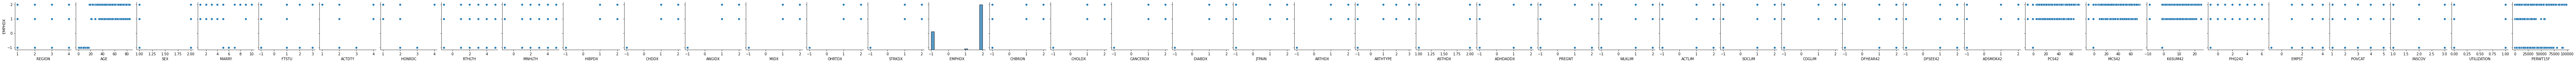

In [ ]:
sns.pairplot(concat_df, y_vars =["EMPHDX"])

This column has the highest correlation in the columns because it is age restricted.
Check for scalar value correlation representation.

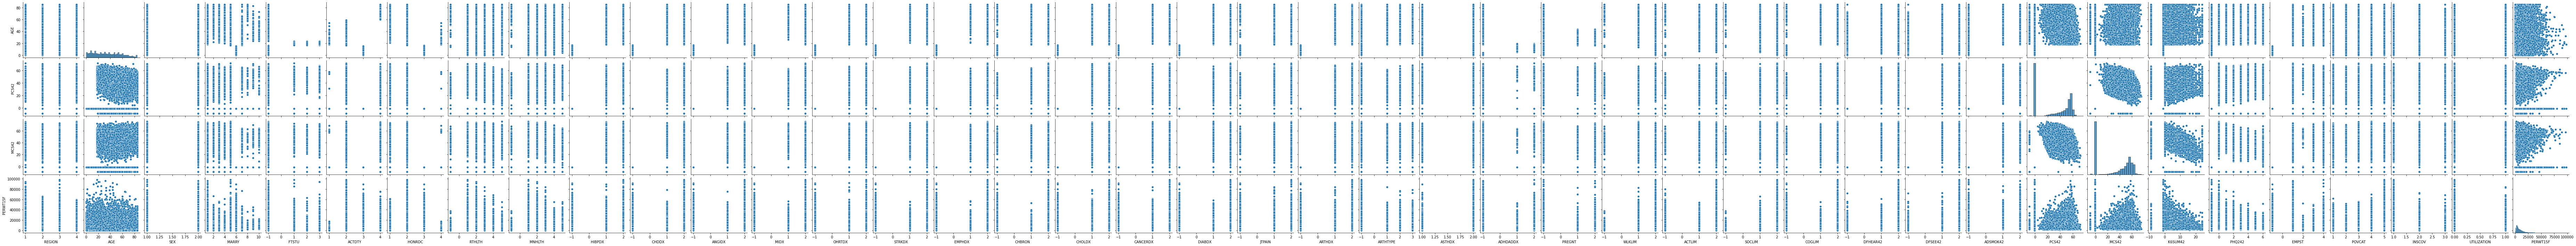

In [ ]:
sns.pairplot(concat_df, y_vars =["AGE", "PCS42", "MCS42", "PERWT15F"])

We could see on the scalar variables, we did not see much of a correlation between other variables. Thus, we can conclude that the variables are mainly independent of each other, other than age-related variables. We can also conclude that the features that we selected represent individual non-correlated variables.

-----
End of Exploratory Data Analysis

### [3.](#Table-of-Contents) Model Development without Debiasing 


First, load all necessary packages

In [ ]:
#pip install aif360

In [ ]:
# ! pip install lime

In [ ]:
### move csv file from content to meps file so that the import below works.
### remember to download the csv file then upload to the colab Files, which will be deleted each time it reconnected
#/content/h181.csv /usr/local/lib/python3.7/dist-packages/aif360/data/raw/meps/h181.csv
! mv /content/h181.csv /usr/local/lib/python3.8/dist-packages/aif360/data/raw/meps/h181.csv

In [ ]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display


# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

### 3.1. Load data & create splits for learning/validating/testing model

In [ ]:
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

In [ ]:
def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

In [ ]:
describe(dataset_orig_panel19_train, dataset_orig_panel19_val, dataset_orig_panel19_test)

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

In [ ]:
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        dataset_orig_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.482305229962759


### 3.2. Learning a Logistic Regression (LR) classifier on original data

##### 3.2.1. Training LR model on original data

In [ ]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

##### 3.2.2. Validating LR model on original data

This function will be used throughout the tutorial to find best threshold using a validation set

In [ ]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [ ]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_orig_panel19,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

Plot metrics with twin x-axes

In [ ]:
def plot(x, x_name, y_left, y_left_name, y_right, y_right_name):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(x, y_left)
    ax1.set_xlabel(x_name, fontsize=16, fontweight='bold')
    ax1.set_ylabel(y_left_name, color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylim(0.5, 0.8)

    ax2 = ax1.twinx()
    ax2.plot(x, y_right, color='r')
    ax2.set_ylabel(y_right_name, color='r', fontsize=16, fontweight='bold')
    if 'DI' in y_right_name:
        ax2.set_ylim(0., 0.7)
    else:
        ax2.set_ylim(-0.25, 0.1)

    best_ind = np.argmax(y_left)
    ax2.axvline(np.array(x)[best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)

Here we plot 1−min(disparate impact,1/disparate impact) since it's possible to overcorrect and end up with a value greater than 1, implying unfairness for the original privileged group. For shorthand, we simply call this 1-min(DI, 1/DI) from now on. We want the plotted metric to be less than 0.2.

In [ ]:
import matplotlib.pyplot as plt

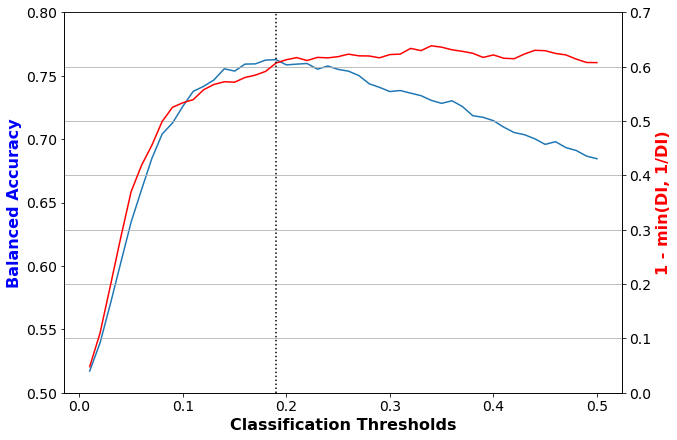

In [ ]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

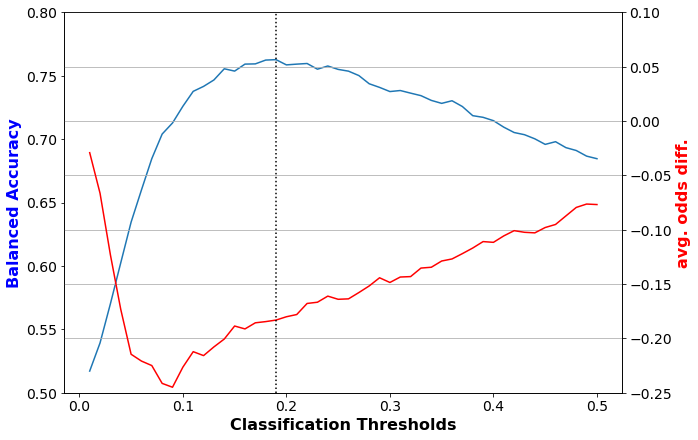

In [ ]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [ ]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [ ]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7627
Corresponding 1-min(DI, 1/DI) value: 0.6066
Corresponding average odds difference value: -0.1831
Corresponding statistical parity difference value: -0.2643
Corresponding equal opportunity difference value: -0.1608
Corresponding Theil index value: 0.0936


##### 3.2.3. Testing LR model on original data

In [ ]:
lr_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=lr_orig_panel19,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [ ]:
describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7759
Corresponding 1-min(DI, 1/DI) value: 0.5738
Corresponding average odds difference value: -0.2057
Corresponding statistical parity difference value: -0.2612
Corresponding equal opportunity difference value: -0.2228
Corresponding Theil index value: 0.0921


The printed line above 

### 3.3. Learning a Random Forest (RF) classifier on original data

##### 3.3.1. Training RF model on original data

In [ ]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

##### 3.3.2. Validating RF model on original data¶

In [ ]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_orig_panel19,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])


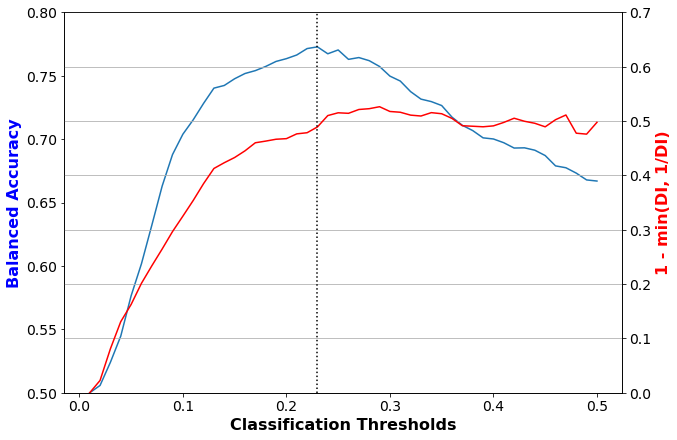

In [ ]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

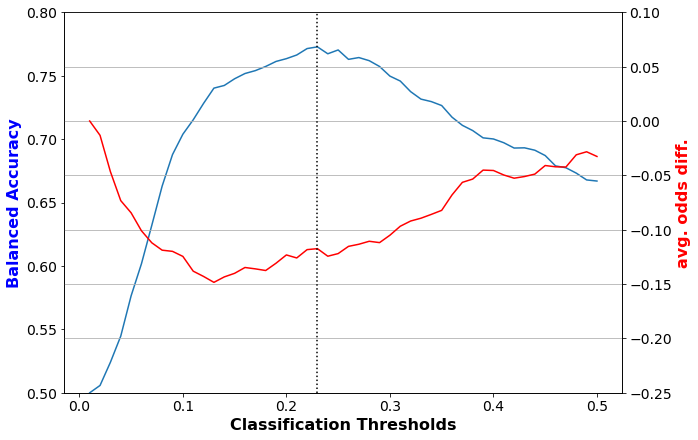

In [ ]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')


In [ ]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7727
Corresponding 1-min(DI, 1/DI) value: 0.4891
Corresponding average odds difference value: -0.1174
Corresponding statistical parity difference value: -0.1952
Corresponding equal opportunity difference value: -0.1076
Corresponding Theil index value: 0.0893


##### 3.3.3. Testing RF model on original data

In [ ]:
rf_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=rf_orig_panel19,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])

In [ ]:
describe_metrics(rf_orig_metrics, [thresh_arr[rf_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7640
Corresponding 1-min(DI, 1/DI) value: 0.5040
Corresponding average odds difference value: -0.1346
Corresponding statistical parity difference value: -0.2121
Corresponding equal opportunity difference value: -0.1141
Corresponding Theil index value: 0.0944


### Section 3 Write Up
### Part-01 LR: Result when we tested Linear Regression model on original data.
**Fairness Metric Summary** 
* Threshold corresponding to Best balanced accuracy: 0.1900, the threshold is the value that indicates the classification of positive class and negative class. For example, if the prediction value is 0.191 (above the threshold), then the classification is positive. A threshold that is higher than 0 in the context of balanced accuracy signals that the prediction result is more biased towards either positive classification or negative classification, which indicate unfairness. 
 
* Best balanced accuracy: 0.7759. Balanced accuracy is the mean between the true positive rate and the true negative rate. It measures the average accuracy obtained from both the minority and the majority class. A score of 0.7759 signals a good model performance in identifying negative and positive classes. However, the metric itself offers trivial indication regarding fairness.
 
* Corresponding 1-min(DI, 1/DI) value: 0.5738, DI stands for disparate impact, which is the probability of positive classification in the unprivileged group divided by the probability of positive classification in the privileged group. In a fair situation, we expected DI or 1 / DI to be close to 1. Therefore, the metric signals **unfairness** as min(DI, 1/DI) is around 0.6: the probability of positive classification is significantly higher in the privileged group or unprivileged group.
 
* Corresponding average odds difference value: -0.2057, the average odds difference value is the average difference in False Positive Rate and True Positive Rate for unprivileged and privileged groups. A value of 0 would indicate equality of chance of odds. Therefore, the metric indicates **unfairness**: The FPR and TPR are certainly different between privileged group and unprivileged group.
 
 
* Corresponding statistical parity difference value: -0.2612, it measures the differences between the probability of positive classification in the unprivileged group and the probability of positive classification in the privileged group. A value that is different than 0 will indicates **unfairness** as probability of positive classification is different between privileged and unprivileged groups.
 
 
 
 
* Corresponding equal opportunity difference value: -0.2228. This metric measures the difference between the true positive rate of the unprivileged group and the true positive rate of the privileged group. A value that is significantly different than 0 will indicates **unfairness** as the true positive rate is different between privileged and unprivileged groups.
 
 
* Corresponding Theil index value: 0.0921. Theil index is the generalized entropy index with alpha = 1. It measures an entropic "distance" the population is away from the "ideal" egalitarian state. 0 will indicate perfect equality, and 1 will indicate maximum inequality. Since the value is not 0, the metric indicates some level of **unfairness**.



### Part-01 RF: Result when we tested Random Forest model on original data.

**Fairness Metric Summary** 
* Threshold corresponding to Best balanced accuracy: 0.2300, the threshold is the value that indicates the classification of positive class and negative class. For example, if the prediction value is 0.231 (above the threshold), then the classification is positive. A threshold that is higher than 0 in the context of balanced accuracy signals that the prediction result is more biased towards either positive classification or negative classification, which indicate unfairness. 
 
* Best balanced accuracy: 0.7640. Balanced accuracy is the mean between the true positive rate and the true negative rate. It measures the average accuracy obtained from both the minority and the majority class. A score of 0.7640 signals a good model performance in identifying negative and positive classes. However, the metric itself offers trivial indication regarding fairness.
 
* Corresponding 1-min(DI, 1/DI) value: 0.5040, DI stands for disparate impact, which is the probability of positive classification in the unprivileged group divided by the probability of positive classification in the privileged group. In a fair situation, we expected DI or 1 / DI to be close to 1. Therefore, the metric signals **unfairness** as min(DI, 1/DI) is around 0.5: the probability of positive classification is significantly higher in the privileged group or unprivileged group.
 
* Corresponding average odds difference value: -0.1346, the average odds difference value is the average difference in False Positive Rate and True Positive Rate for unprivileged and privileged groups. A value of 0 would indicate equality of chance of odds. Therefore, the metric indicates **unfairness**: The FPR and TPR are certainly different between privileged group and unprivileged group.
 
 
* Corresponding statistical parity difference value: -0.2121, it measures the differences between the probability of positive classification in the unprivileged group and the probability of positive classification in the privileged group. A value that is different than 0 will indicates **unfairness** as probability of positive classification is different between privileged and unprivileged groups.
 
 
 
 
* Corresponding equal opportunity difference value: -0.1141. This metric measures the difference between the true positive rate of the unprivileged group and the true positive rate of the privileged group. A value that is significantly different than 0 will indicates **unfairness** as the true positive rate is different between privileged and unprivileged groups.
 
 
* Corresponding Theil index value: 0.0944. Theil index is the generalized entropy index with alpha = 1. It measures an entropic "distance" the population is away from the "ideal" egalitarian state. 0 will indicate perfect equality, and 1 will indicate maximum inequality. Since the value is not 0, the metric indicates some level of **unfairness**.


We can use the tree diagram to help determine the statistical fairness we should strive for. While we care about individual fairness, we will prioritize group fairness in this project. Our predictive outcome does correlate with protected classes like race, gender, and age. We want to correct existing structural bias in the world. In addition, we want to support underprivileged groups and prevent the reinforcement of historical biases. Based on our objective, it seems that we should pursue demographic parity, which will be reflected by metrics like disparate_impact and statistical_parity_differences. Furthermore, knowing that we will choose group fairness as our priority lead us to pick between the two approaches WAE (we’re all equal) Vs. WYSIWYG (what you see is what you get). We are likely to choose the WAE worldview, which supports that all groups have similar abilities with respect to the task. 

We should choose and prioritize metrics that are more fitted with our objective. For example, if a bias mitigation method can improve the group fairness metrics by a lot while compromising individual fairness metrics by a trivial amount, we might conclude that the bias mitigation methods have positive impacts. However, that doesn’t mean should not neglect other metrics when the differences are significant. We intend to conduct a holistic review based on all the fairness metrics, even though few will be given higher weight. 

We will first review the documentation of the fairness metrics. In many cases, metrics can have different definitions in various use cases. We will certainly reach out to professors and instructors for their suggestions. And we will eventually pick the metrics that we think best describe the situation.

Our objective is to strive for group fairness (demographic parity and WAE).
Therefore, we will focus our evaluation on the metrics **Corresponding 1-min(DI, 1/DI)** and the **Corresponding statistical parity difference value**. The metrics derive from disparate_impact and statistical_parity_differences, which both reflect demographic parity. 

Corresponding 1-min(DI, 1/DI) value: DI stands for disparate impact, which is the probability of positive classification in the unprivileged group divided by the probability of positive classification in the privileged group.

Corresponding statistical parity difference value: it measures the differences between the probability of positive classification in the unprivileged group and the probability of positive classification in the privileged group. 


### [4.](#Table-of-Contents) Additional Model Development



### 4.1A Load data & create splits for learning/validating/testing model

In [ ]:
# Use the same methods from Section 3
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

### 4.1B Utilize findings from your EDA to complete any additional mmodel development

In the previous EDA section, we noticed that a lot of the variables are age restricted. We wonder how much we can predict from just from age and age restricted columns that are related to it.

In [ ]:
list(map(descript_dict.get, list(map(lambda x: revert_dct.get(x) if revert_dct.get(x) != None else x, df_panel_19_reduced.columns))))

['CENSUS REGION - R5/3',
 'AGE - R5/3 (EDITED/IMPUTED)',
 'SEX',
 None,
 'MARITAL STATUS - R5/3 (EDITED/IMPUTED)',
 'STUDENT STATUS IF AGES 17-23 - R5/3',
 'MILITARY FULL-TIME ACTIVE DUTY - R5/3',
 'HONORABLY DISCHARGED FROM MILITARY',
 'PERCEIVED HEALTH STATUS - RD 5/3',
 'PERCEIVED MENTAL HEALTH STATUS - RD 5/3',
 'HIGH BLOOD PRESSURE DIAG (>17)',
 'CORONARY HRT DISEASE DIAG (>17)',
 'ANGINA DIAGNOSIS (>17)',
 'HEART ATTACK (MI) DIAG (>17)',
 'OTHER HEART DISEASE DIAG (>17)',
 'STROKE DIAGNOSIS (>17)',
 'EMPHYSEMA DIAGNOSIS (>17)',
 'CHRONC BRONCHITS LAST 12 MTHS (>17)-R5/3',
 'HIGH CHOLESTEROL DIAGNOSIS (>17)',
 'CANCER DIAGNOSIS (>17)',
 'DIABETES DIAGNOSIS (>17)',
 'JOINT PAIN LAST 12 MONTHS (>17) - RD 5/3',
 'ARTHRITIS DIAGNOSIS (>17)',
 'TYPE OF ARTHRITIS DIAGNOSED (>17)',
 'ASTHMA DIAGNOSIS',
 'ADHDADD DIAGNOSIS (5-17)',
 'PREGNANT DURING REF PERIOD - RD 5/3',
 'LIMITATION IN PHYSICAL FUNCTIONING-RD5/3',
 'ANY LIMITATION WORK/HOUSEWRK/SCHL-RD 5/3',
 'SOCIAL LIMITATIONS - RD 5/3

From above, we would find that the cut of for the varibales that are age related are 5, 15, 23. It would be useful to see whether such age numbers would have an effect on the prediction itself. Proving that would allow us to see whether age restricted data collection would have an effect on the prediction itself.

In [ ]:
train_age = pd.DataFrame(dict(zip(["AGE",">=5", "<5", ">17", "<=17", ">23", "<=23"], 
                 [dataset_orig_panel19_train.convert_to_dataframe()[0]["AGE"],
              dataset_orig_panel19_train.convert_to_dataframe()[0]["AGE"] >= 5,
              dataset_orig_panel19_train.convert_to_dataframe()[0]["AGE"] < 5,
              dataset_orig_panel19_train.convert_to_dataframe()[0]["AGE"] > 17,
              dataset_orig_panel19_train.convert_to_dataframe()[0]["AGE"] <= 17,
              dataset_orig_panel19_train.convert_to_dataframe()[0]["AGE"] > 23,
              dataset_orig_panel19_train.convert_to_dataframe()[0]["AGE"] <= 23
              ])))
train_age.head()

AGE   >=5     <5    >17   <=17    >23   <=23
3894  21.0  True  False   True  False  False   True
9303  53.0  True  False   True  False   True  False
1851  62.0  True  False   True  False   True  False
5254  11.0  True  False  False   True  False   True
5487  30.0  True  False   True  False   True  False

In [ ]:
val_age = pd.DataFrame(dict(zip(["AGE",">=5", "<5", ">17", "<=17", ">23", "<=23"], 
                 [dataset_orig_panel19_val.convert_to_dataframe()[0]["AGE"],
              dataset_orig_panel19_val.convert_to_dataframe()[0]["AGE"] >= 5,
              dataset_orig_panel19_val.convert_to_dataframe()[0]["AGE"] < 5,
              dataset_orig_panel19_val.convert_to_dataframe()[0]["AGE"] > 17,
              dataset_orig_panel19_val.convert_to_dataframe()[0]["AGE"] <= 17,
              dataset_orig_panel19_val.convert_to_dataframe()[0]["AGE"] > 23,
              dataset_orig_panel19_val.convert_to_dataframe()[0]["AGE"] <= 23
              ])))
test_age = pd.DataFrame(dict(zip(["AGE",">=5", "<5", ">17", "<=17", ">23", "<=23"], 
                 [dataset_orig_panel19_test.convert_to_dataframe()[0]["AGE"],
              dataset_orig_panel19_test.convert_to_dataframe()[0]["AGE"] >= 5,
              dataset_orig_panel19_test.convert_to_dataframe()[0]["AGE"] < 5,
              dataset_orig_panel19_test.convert_to_dataframe()[0]["AGE"] > 17,
              dataset_orig_panel19_test.convert_to_dataframe()[0]["AGE"] <= 17,
              dataset_orig_panel19_test.convert_to_dataframe()[0]["AGE"] > 23,
              dataset_orig_panel19_test.convert_to_dataframe()[0]["AGE"] <= 23
              ])))

In [ ]:
age_lr_model = LogisticRegression(solver='liblinear', random_state=1)
age_lr_model.fit(train_age, dataset_orig_panel19_train.labels.ravel())

LogisticRegression(random_state=1, solver='liblinear')

In [ ]:
# Importing tools for crossValidation
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

In [ ]:
# Create a list where train data indices are -1 and validation data indices are 0
split_index = ([-1]*(train_age.shape[0])
                  +[0]*(val_age.shape[0]))
# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

In [ ]:
parameters = {"penalty": ["l1", "l2", "elasticnet", "none"],
              "dual": [True, False],
              "C": 10**np.arange(-4, 4, dtype=float),
              "fit_intercept": [True, False],
              "max_iter": [3000]
}

In [ ]:
clf_age_lr_model = GridSearchCV(age_lr_model, parameters, cv=pds, scoring='balanced_accuracy').fit(
  pd.concat([train_age, val_age]), 
  np.append(dataset_orig_panel19_train.labels, dataset_orig_panel19_val.labels).ravel())

In [ ]:
clf_age_lr_model.best_params_

{'C': 1.0,
 'dual': True,
 'fit_intercept': True,
 'max_iter': 3000,
 'penalty': 'l2'}

In [ ]:
clf_age_lr_model.score(val_age, dataset_orig_panel19_val.labels.ravel())

0.5349529785382919

In [ ]:
clf_age_lr_model.score(test_age, dataset_orig_panel19_test.labels.ravel())

0.5557295710110723

Though age as a model itself is not perfomring better when comparing with other models, with a validation set and test set accuracy score both higher than > 0.5 using the best CV models, it shows that age has a sizeable influence towards medical expenditures. Therefore, we believe restircting some of the variables by age may increased bias in the model itself.

In [ ]:
 # Examples:

# Feature selection 
# encoding
# binning categorical features

# Feel free to use the codebook from MEPS to explore other variables

In [ ]:
#Binning categorical features


### 4.2. Learning a Logistic Regression (LR) classifier on original data

In [ ]:
#Feature selection using recursive feature elimination
from sklearn.feature_selection import RFE
dataset = dataset_orig_panel19_train
rfe=RFE(LogisticRegression(solver='liblinear', random_state=1),n_features_to_select=70)
model = make_pipeline(StandardScaler(),rfe,LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_new_panel19=model.fit(dataset.features, dataset.labels.ravel())

In [ ]:
# Use the same methods from Section 3

In [ ]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_new_panel19,
                   thresh_arr=thresh_arr)
lr_new_best_ind = np.argmax(val_metrics['bal_acc'])

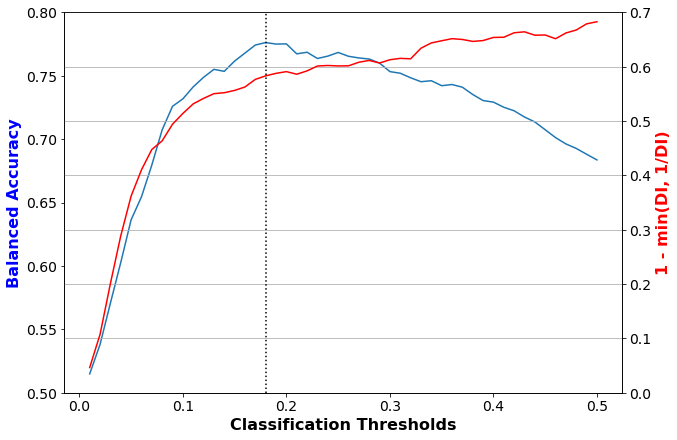

In [ ]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

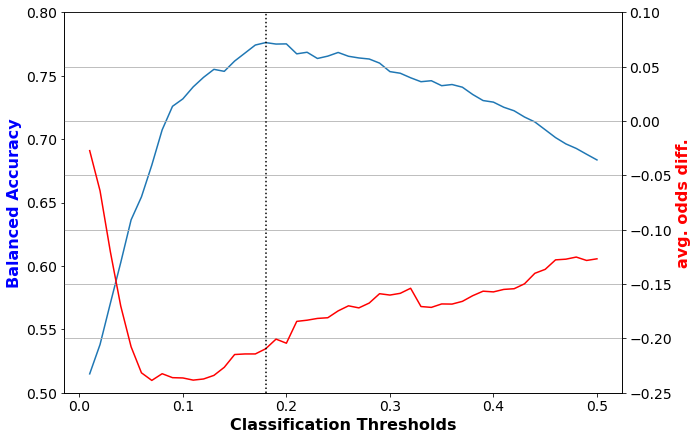

In [ ]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [ ]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1800
Best balanced accuracy: 0.7761
Corresponding 1-min(DI, 1/DI) value: 0.5830
Corresponding average odds difference value: -0.2095
Corresponding statistical parity difference value: -0.2777
Corresponding equal opportunity difference value: -0.2033
Corresponding Theil index value: 0.0905


In [ ]:
lr_new_metrics = test(dataset=dataset_orig_panel19_test,
                       model=lr_new_panel19,
                       thresh_arr=[thresh_arr[lr_new_best_ind]])

In [ ]:
describe_metrics(lr_new_metrics, [thresh_arr[lr_new_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1800
Best balanced accuracy: 0.7638
Corresponding 1-min(DI, 1/DI) value: 0.6012
Corresponding average odds difference value: -0.2193
Corresponding statistical parity difference value: -0.2799
Corresponding equal opportunity difference value: -0.2374
Corresponding Theil index value: 0.0922


### 4.3. Learning a Random Forest (RF) classifier on original data

In [ ]:
#Feature selection using recursive feature elimination
dataset = dataset_orig_panel19_train
rfe=RFE(RandomForestClassifier(n_estimators=500, min_samples_leaf=25),n_features_to_select=70)
model = make_pipeline(StandardScaler(),rfe,RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_new_panel19=model.fit(dataset.features, dataset.labels.ravel())

In [ ]:
# Use the same methods from Section 3

In [ ]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_new_panel19,
                   thresh_arr=thresh_arr)
rf_new_best_ind = np.argmax(val_metrics['bal_acc'])

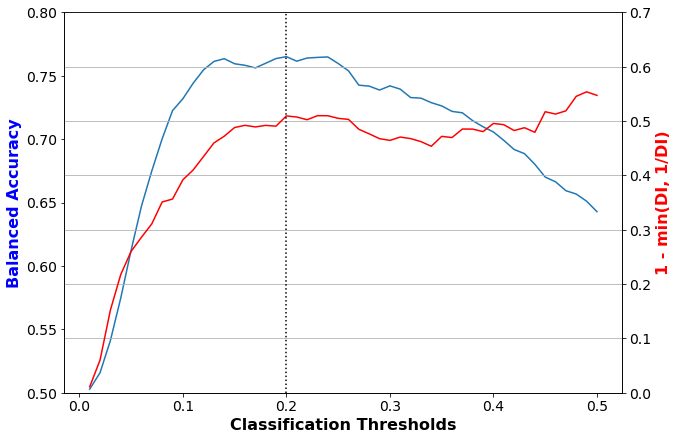

In [ ]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

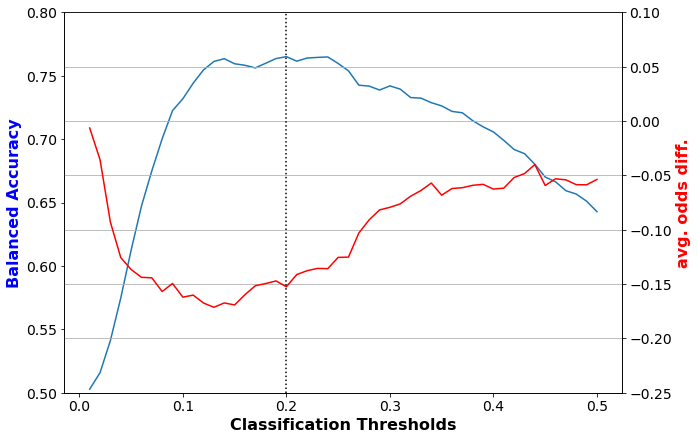

In [ ]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [ ]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2000
Best balanced accuracy: 0.7650
Corresponding 1-min(DI, 1/DI) value: 0.5094
Corresponding average odds difference value: -0.1525
Corresponding statistical parity difference value: -0.2244
Corresponding equal opportunity difference value: -0.1378
Corresponding Theil index value: 0.0939


In [ ]:
rf_new_metrics = test(dataset=dataset_orig_panel19_test,
                       model=rf_new_panel19,
                       thresh_arr=[thresh_arr[rf_new_best_ind]])

In [ ]:
describe_metrics(rf_new_metrics, [thresh_arr[rf_new_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2000
Best balanced accuracy: 0.7671
Corresponding 1-min(DI, 1/DI) value: 0.5143
Corresponding average odds difference value: -0.1235
Corresponding statistical parity difference value: -0.2079
Corresponding equal opportunity difference value: -0.1104
Corresponding Theil index value: 0.0889


Using recursive feature elimination to filter the number of features used on the models by about half showed little impact on their performance in terms of our fairness metrics.

### Section 4 Write Up

### Part-01 Logistic Regression


_Fairness Metrics_
  * Threshold corresponding to Best balanced accuracy: 0.1800. Our threshold value remains similar to our original results which was 0.1900.
  * Best balanced accuracy: 0.7638. The best balanced accuracy is only slightly below our previous results of 0.7759. This means that our model accuracy is still performing well for our minority and majority classes, but it may not be a good measure for fairness.
  * Corresponding 1-min(DI, 1/DI) value: 0.6012. TThis is not an improvement as our previous value was 0.5738 and our disparate impact error increased to 0.6012. This is still a signal for unfairness as the positive bias remains towards the priviedged group.
  * Corresponding average odds difference value: -0.2193. The average odds difference is still close to our original result of -0.2057.
  * Corresponding statistical parity difference value: -0.2799. Statistical parity difference worsens slightly from -0.2612.
  * Corresponding equal opportunity difference value: -0.2374. Equal opportunity difference also remains slightly worse as our original value was -0.2228.
  * Corresponding Theil index value: 0.0922. The Theil index value remains nearly unchanged whihc indicates that there still exists some unfairness in the performance.

### Part-01 Random Forest

_Fairness Metrics_
  * Threshold corresponding to Best balanced accuracy: 0.2000. Our threshold value has lowered from the previous 0.2300.
  * Best balanced accuracy: 0.7671. The best balanced accuracy remains nearly unchangedin comparison to the previous results of 0.7640.
  * Corresponding 1-min(DI, 1/DI) value: 0.5143. As opposed to the linear regression model, here the disparate impact value is only slighlty higher as the original value was 0.5040.
  * Corresponding average odds difference value: -0.1235. Average odds difference value has not been largely effected from the original result of -0.1346.
  * Corresponding statistical parity difference value: -0.2079. Statistical parity difference value decreases slightly from our original value of -0.2121.
  * Corresponding equal opportunity difference value: -0.1104. Equal opportunity difference remains nearly the same with the previous value being -0.1141.
  * Corresponding Theil index value: 0.0889. The Theil index value has slightly decreased from the previous value of 0.0944 which means that some of the unfairness has been mitigated.

### Part-02 Model and Fairness Metric Recommendation

Filtering for important features and binning the ages didn't provide significantly better model performance. However, we did find that the age variable has a significant impact on the model's performance and is an important feature. If we wanted to procede with the average odds or equal opportunity difference being our primary metric for fairness, we would want to prioritize the random forest classification model. If we wanted to focus on disparate impact as our metric for fairness, we would also go with random forest with disparate impact error as it performed significantly better than the logistic regression model.

### [5.](#Table-of-Contents) Bias Mitigation

### [5A.](#Table-of-Contents) Bias mitigation using pre-processing technique, Reweighing - AIF360 Example


In [ ]:
#Follow the full AIF360 Example

### 5A.1. Transform data

In [ ]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_panel19_train = RW.fit_transform(dataset_orig_panel19_train)

Metrics for transformed data

In [ ]:
metric_transf_panel19_train = BinaryLabelDatasetMetric(
        dataset_transf_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_panel19_train = MetricTextExplainer(metric_transf_panel19_train)

print(explainer_transf_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0


### 5A.2. Learning a Logistic Regression (LR) classifier on data transformed by reweighing

#### 5A.2.1. Training LR model after reweighing

In [ ]:
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 5A.2.2. Validating  LR model after reweighing

In [ ]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_transf_panel19,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

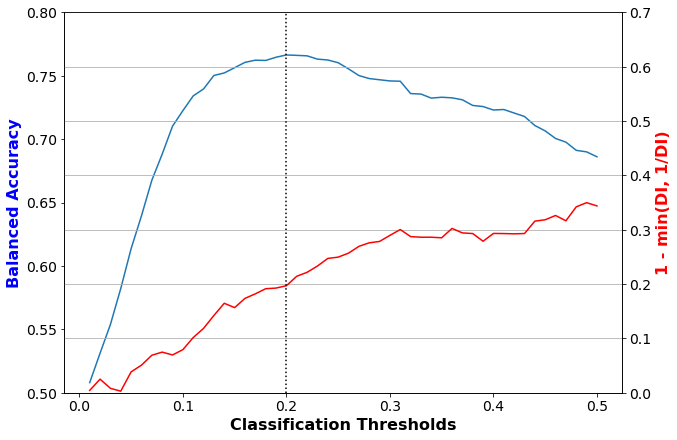

In [ ]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

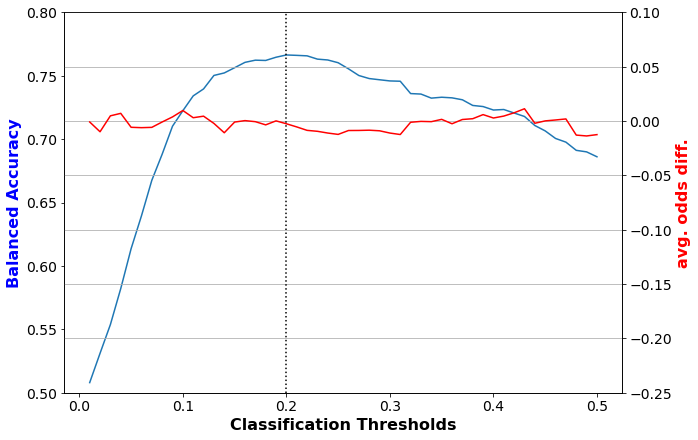

In [ ]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [ ]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2000
Best balanced accuracy: 0.7663
Corresponding 1-min(DI, 1/DI) value: 0.1970
Corresponding average odds difference value: -0.0025
Corresponding statistical parity difference value: -0.0685
Corresponding equal opportunity difference value: -0.0033
Corresponding Theil index value: 0.0945


#### 5A.2.3. Testing  LR model after reweighing

In [ ]:
lr_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=lr_transf_panel19,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])

In [ ]:
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2000
Best balanced accuracy: 0.7570
Corresponding 1-min(DI, 1/DI) value: 0.2260
Corresponding average odds difference value: 0.0007
Corresponding statistical parity difference value: -0.0791
Corresponding equal opportunity difference value: 0.0050
Corresponding Theil index value: 0.0917


The fairness metrics for the logistic regression model learned after reweighing are well improved, and thus the model is much more fair relative to the logistic regression model learned from the original data.

### 5A.3. Learning a Random Forest (RF) classifier on data transformed by reweighing

#### 5A.3.1. Training  RF model after reweighing

In [ ]:
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 5A.3.2. Validating  RF model after reweighing

In [ ]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_transf_panel19,
                   thresh_arr=thresh_arr)
rf_transf_best_ind = np.argmax(val_metrics['bal_acc'])

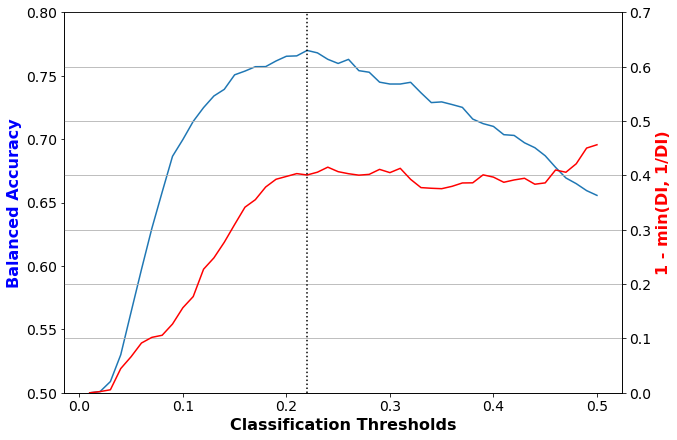

In [ ]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

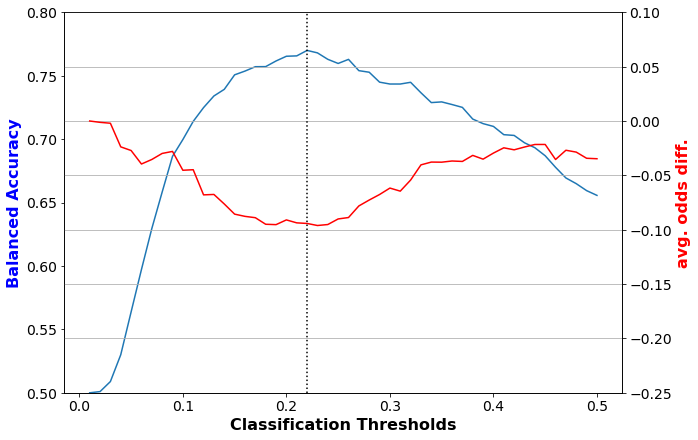

In [ ]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [ ]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7699
Corresponding 1-min(DI, 1/DI) value: 0.4007
Corresponding average odds difference value: -0.0942
Corresponding statistical parity difference value: -0.1685
Corresponding equal opportunity difference value: -0.0799
Corresponding Theil index value: 0.0917


#### 5A.3.3. Testing  RF model after reweighing

In [ ]:
rf_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=rf_transf_panel19,
                         thresh_arr=[thresh_arr[rf_transf_best_ind]])

In [ ]:
describe_metrics(rf_transf_metrics, [thresh_arr[rf_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7666
Corresponding 1-min(DI, 1/DI) value: 0.3990
Corresponding average odds difference value: -0.0736
Corresponding statistical parity difference value: -0.1589
Corresponding equal opportunity difference value: -0.0612
Corresponding Theil index value: 0.0890


After reweighing, the fairness on both models are improved. However, we find that the logisitic regression model pulls ahead of the random forest model which goes against the previous trend we were seeing. While our fairness metrics and disparate impact are improved, there is still signs of unfairness.

### [5B.](#Table-of-Contents) Prejudice Remover (in-processing bias mitigation) -  AIF360 Example


In [ ]:
#Follow the full AIF360 Example

### 5B.1. Learning a Prejudice Remover (PR) model on original data

#### 5B.1.1. Training a PR model

In [ ]:
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_orig_panel19_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig_panel19 = model.fit(dataset)

#### 5B.1.2. Validating PR model

In [ ]:
thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_orig_panel19_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig_panel19,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

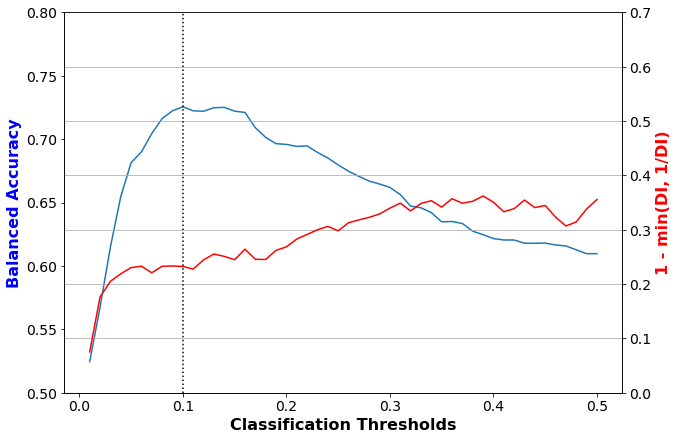

In [ ]:
disp_imp = np.array(val_metrics['disp_imp'])
disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     disp_imp_err, '1 - min(DI, 1/DI)')

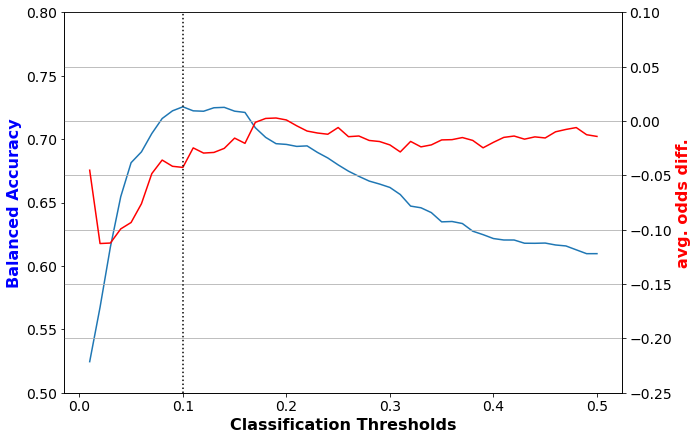

In [ ]:
plot(thresh_arr, 'Classification Thresholds',
     val_metrics['bal_acc'], 'Balanced Accuracy',
     val_metrics['avg_odds_diff'], 'avg. odds diff.')

In [ ]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1000
Best balanced accuracy: 0.7255
Corresponding 1-min(DI, 1/DI) value: 0.2324
Corresponding average odds difference value: -0.0427
Corresponding statistical parity difference value: -0.1051
Corresponding equal opportunity difference value: -0.0313
Corresponding Theil index value: 0.0950


#### 5B.1.3. Testing PR model

In [ ]:
dataset = dataset_orig_panel19_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig_panel19,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])

In [ ]:
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1000
Best balanced accuracy: 0.6973
Corresponding 1-min(DI, 1/DI) value: 0.3071
Corresponding average odds difference value: -0.0774
Corresponding statistical parity difference value: -0.1508
Corresponding equal opportunity difference value: -0.0511
Corresponding Theil index value: 0.0984


Prejudice removerprovides a much more fair model,but it comes at the cost of a considerable decrease in best balanced accuracy. This makes utilizing this technique in this scenario an issue due to performance.

### [5C.](#Table-of-Contents) Bias mitigation using a technique of your own


In [ ]:
#Choose your own technique!

In [ ]:
#Reject Option Classification (Post-processing)
#With https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_reject_option_classification.ipynb as example

### Logistic Regression w/ROC(post-processing)

In [ ]:
from collections import OrderedDict
#from aif360: https://github.com/Trusted-AI/AIF360/blob/master/examples/common_utils.py
def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [ ]:
dataset = dataset_orig_panel19_train
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(dataset.features)
y_train = dataset.labels.ravel()

lr_orig_panel19 = LogisticRegression(solver="liblinear",random_state=1)
lr_orig_panel19.fit(X_train, y_train)
y_train_pred = lr_orig_panel19.predict(X_train)

pos_ind = np.where(lr_orig_panel19.classes_ == dataset.favorable_label)[0][0]
dataset_orig_train_pred = dataset.copy(deepcopy=True)
dataset_orig_train_pred.labels = y_train_pred

In [ ]:
dataset_orig_valid_pred = dataset_orig_panel19_val.copy(deepcopy=True)
X_valid = standard_scaler.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lr_orig_panel19.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_panel19_test.copy(deepcopy=True)
X_test = standard_scaler.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lr_orig_panel19.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [ ]:
num_thresh = 50
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.5, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_panel19_val,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy:",np.max(ba_arr))
print("Threshold:", best_class_thresh)

Best balanced accuracy: 0.7733701671597903
Threshold: 0.18000000000000002


In [ ]:
from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification

In [ ]:
ROC_model = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name="Statistical parity difference",
                                  metric_ub=0.05, metric_lb=-0.05)
ROC_model = ROC_model.fit(dataset_orig_panel19_val, dataset_orig_valid_pred)

In [ ]:
#Original validation set
fav_inds = dataset_orig_valid_pred.scores > best_class_thresh
dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
lr_metric_valid_bef = compute_metrics(dataset_orig_panel19_val, dataset_orig_valid_pred, unprivileged_groups, privileged_groups)

Balanced accuracy = 0.7734
Statistical parity difference = -0.2626
Disparate impact = 0.4343
Average odds difference = -0.1972
Equal opportunity difference = -0.1949
Theil index = 0.0916


In [ ]:
#Post-processed validation set
dataset_post_valid_pred = ROC_model.predict(dataset_orig_valid_pred)
lr_metric_valid_aft = compute_metrics(dataset_orig_panel19_val, dataset_post_valid_pred, unprivileged_groups, privileged_groups)

Balanced accuracy = 0.7661
Statistical parity difference = -0.0478
Disparate impact = 0.8653
Average odds difference = 0.0174
Equal opportunity difference = 0.0149
Theil index = 0.0934


In [ ]:
#Original test set
fav_inds = dataset_orig_test_pred.scores > best_class_thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

lr_metric_test_bef = compute_metrics(dataset_orig_panel19_test, dataset_orig_test_pred, unprivileged_groups, privileged_groups)

Balanced accuracy = 0.7640
Statistical parity difference = -0.2679
Disparate impact = 0.4092
Average odds difference = -0.2040
Equal opportunity difference = -0.2178
Theil index = 0.0924


In [ ]:
#Post-processed test set
dataset_post_test_pred = ROC_model.predict(dataset_orig_test_pred)
lr_metric_test_aft = compute_metrics(dataset_orig_panel19_test, dataset_post_test_pred, unprivileged_groups, privileged_groups)

Balanced accuracy = 0.7513
Statistical parity difference = -0.0521
Disparate impact = 0.8550
Average odds difference = 0.0187
Equal opportunity difference = 0.0108
Theil index = 0.0936


In [ ]:
dataset = dataset_orig_panel19_test.copy()
thresh_arr = np.linspace(0.01, 1.0, 50)
roc_orig_best_ind = np.argmax(val_metrics['bal_acc'])

In [ ]:
roc_orig_metrics = test(dataset,model=ROC_model,thresh_arr=[thresh_arr[roc_orig_best_ind]])

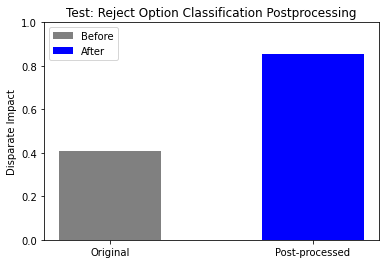

In [ ]:
import matplotlib.pyplot as plt
x = ['Original']
x2=["Post-processed"]
#y1 = [1-min(metric_test_bef["Disparate impact"],1/metric_test_bef["Disparate impact"])]
#y2 = [1-min(metric_test_aft["Disparate impact"],1/metric_test_aft["Disparate impact"])]
y1=lr_metric_test_bef["Disparate impact"]
y2=lr_metric_test_aft["Disparate impact"]

labels=["Before","After"]
plt.bar(x, y1, color=["grey"],width=0.5)
plt.bar(x2, y2, color=['b'],width=0.5)
plt.ylim(0.0, 1.0)
plt.title("Test: Reject Option Classification Postprocessing")
plt.ylabel("Disparate Impact")
plt.legend(labels)
plt.show()
#closer to 1 means bias is mitigated

### Random Forest Classifer w/ROC(post-processing)

In [ ]:
dataset = dataset_orig_panel19_train
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(dataset.features)
y_train = dataset.labels.ravel()

rf_orig_panel19 = RandomForestClassifier(n_estimators=500, min_samples_leaf=25,random_state=1)
rf_orig_panel19.fit(X_train, y_train)
y_train_pred = rf_orig_panel19.predict(X_train)


pos_ind = np.where(lr_orig_panel19.classes_ == dataset.favorable_label)[0][0]
dataset_orig_train_pred = dataset.copy(deepcopy=True)
dataset_orig_train_pred.labels = y_train_pred

In [ ]:
dataset_orig_valid_pred = dataset_orig_panel19_val.copy(deepcopy=True)
X_valid = standard_scaler.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = rf_orig_panel19.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_panel19_test.copy(deepcopy=True)
X_test = standard_scaler.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = rf_orig_panel19.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [ ]:
num_thresh = 50
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.5, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_panel19_val,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy:",np.max(ba_arr))
print("Threshold:", best_class_thresh)

Best balanced accuracy: 0.7641544910200787
Threshold: 0.22


In [ ]:
ROC_model = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name="Statistical parity difference",
                                  metric_ub=0.05, metric_lb=-0.05)
ROC_model = ROC_model.fit(dataset_orig_panel19_val, dataset_orig_valid_pred)

In [ ]:
#Original validation set
fav_inds = dataset_orig_valid_pred.scores > best_class_thresh
dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label

rf_metric_valid_bef = compute_metrics(dataset_orig_panel19_val, dataset_orig_valid_pred, unprivileged_groups, privileged_groups)

Balanced accuracy = 0.7642
Statistical parity difference = -0.2086
Disparate impact = 0.4894
Average odds difference = -0.1462
Equal opportunity difference = -0.1466
Theil index = 0.0953


In [ ]:
#Post-processed validation set
dataset_post_valid_pred = ROC_model.predict(dataset_orig_valid_pred)
rf_metric_valid_aft = compute_metrics(dataset_orig_panel19_val, dataset_post_valid_pred, unprivileged_groups, privileged_groups)

Balanced accuracy = 0.7595
Statistical parity difference = -0.0384
Disparate impact = 0.8982
Average odds difference = 0.0373
Equal opportunity difference = 0.0534
Theil index = 0.0923


In [ ]:
#Original test set
fav_inds = dataset_orig_test_pred.scores > best_class_thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

rf_metric_test_bef = compute_metrics(dataset_orig_panel19_test, dataset_orig_test_pred, unprivileged_groups, privileged_groups)

Balanced accuracy = 0.7672
Statistical parity difference = -0.2024
Disparate impact = 0.4606
Average odds difference = -0.1276
Equal opportunity difference = -0.1296
Theil index = 0.0907


In [ ]:
#Post-processed test set
dataset_post_test_pred = ROC_model.predict(dataset_orig_test_pred)
rf_metric_test_aft = compute_metrics(dataset_orig_panel19_test, dataset_post_test_pred,unprivileged_groups, privileged_groups)

Balanced accuracy = 0.7568
Statistical parity difference = -0.0175
Disparate impact = 0.9508
Average odds difference = 0.0704
Equal opportunity difference = 0.0845
Theil index = 0.0902


In [ ]:
dataset = dataset_orig_panel19_test.copy()
thresh_arr = np.linspace(0.01, 1.0, 50)
roc_orig_best_ind = np.argmax(val_metrics['bal_acc'])

In [ ]:
roc_orig_metrics = test(dataset,model=ROC_model,thresh_arr=[thresh_arr[roc_orig_best_ind]])

In [ ]:
#describe_metrics(roc_orig_metrics, [thresh_arr[pr_orig_best_ind]])

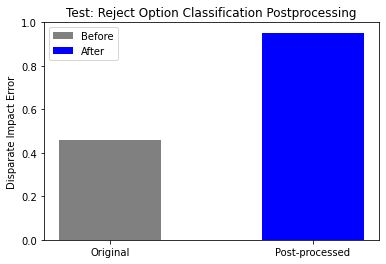

In [ ]:
x = ['Original']
x2=["Post-processed"]
#y1 = [1-min(metric_test_bef["Disparate impact"],1/metric_test_bef["Disparate impact"])]
#y2 = [1-min(metric_test_aft["Disparate impact"],1/metric_test_aft["Disparate impact"])]
y1=rf_metric_test_bef["Disparate impact"]
y2=rf_metric_test_aft["Disparate impact"]

labels=["Before","After"]
plt.bar(x, y1, color=["grey"],width=0.5)
plt.bar(x2, y2, color=['b'],width=0.5)
plt.ylim(0.0, 1.0)
plt.title("Test: Reject Option Classification Postprocessing")
plt.ylabel("Disparate Impact Error")
plt.legend(labels)
plt.show()
#closer to 1 means bias mitigated

---

## Section 5 Discussion


Reweighing is a preprocessing technique where we apply a different weight to different groups in our sensitive attribute, race, in order to establish fairness prior to the classification stage.

Through reweighing, our concern was with fairness metrics concerning groups and these metrics showed that group biases were mitigated. In turn, we observed that our theil index or individual fairness metric was largely unchanged.

Both models exhibit good best-balanced accuracy. Although both models perform well for average odds and equal opportunity difference fairness metrics, the logistic regression model performs better in terms of overall fairness due to its performance on statistical parity difference and disparate impact.

We would recommend this preprocessing mitigation technique for the use case since the disparate impact or bias we are trying to mitigate can arise due to racial biases in the field and lack of representation in the data. Reweighing allows us to address this at the beginning of the process to both mitigate bias as well as keep accuracy.

Prejudice remover is an in-processing bias mitigation technique that appends a new regularization term or weight that considers bias or discrimination. The new regularized model is then used for predictions.
This in-process bias mitigation technique directly addresses social factors that would normally result in these classifiers negatively impacting underprivileged groups or communities. These negative impacts are what our models are trying to mitigate.

The prejudice remover model performs better in terms of our fairness metric with considerable improvement in average odds difference, statistical parity difference, and disparate impact. Although, there’s room for more improvement in equal opportunity difference and lower best-balanced accuracy.

While the benefits in terms of our fairness metrics are present, the cost of the lower best-balanced accuracy is something that would need to be weighed before recommending the model.
Reject option classification is a post-processing technique that provides more favorable outcomes to our underprivileged class and also provides more unfavorable results to our privileged class depending on an uncertainty threshold in the classification.

With reject option classification, our group fairness is significantly improved as our metrics indicate that bias was mitigated across our four fairness metrics, with our theil index remaining mostly unchanged.
After post-processing, both models retain their best-balanced accuracy of around 0.75. Additionally, both models see a disparate impact score of around 1, which is fair, as well as improvements in statistical parity difference, average odds difference, and equal opportunity difference.

We would likely recommend this post-processing bias mitigation technique for this use case as it essentially can address possible social inequities between the underprivileged and privileged groups by providing more favorable outcomes to our underprivileged group. In turn, there would be more unfavorable outcomes for our privileged group within a decision boundary. This means that for our purposes, the group fairness in our high utilization classification would be considered fair, but individual fairness issues may still be present.
Some factors to consider during AI model development and performance are reliability and transparency. The ultimate goal of an AI model is having it produce the best outcomes, so making sure the model is reliable is an important factor to incorporate in its development. Reliability could be vulnerable to introducing bias because of the lack of connection between bias detection and accuracy in a model. Being completely focused on a model’s accuracy/performance could make bias undetected. Transparency is another factor to consider in both an AI model development and performance. Transparency is crucial for model development cause it facilitates a way for others that want to use the model to easily implement it.

Statistical parity difference and balanced accuracy are the metrics we should use to access the downstream metrics of AI. Statistical parity difference evaluates the difference between privileged and non-privileged classes in our dataset.

Disparate impact is the unintentional practices that lead to discrimination. Notable through policies that implement disparate impact in ways the policies are constructed and implemented. Many factors can have an impact that can lead to bias or disparate impact in communities of concern, including the features being utilized. Certain features can lead to disparate impact, including income, location, or medical conditions. Specifically, with the data being used in this bias mitigation, medical conditions such as diabetes or obesity can create a bias towards a demographic with fewer medical conditions. People with diabetes or other medical conditions are placed into groups of high risk compared to others. Individuals within the high-risk groups might receive more medical care because of their medical conditions.

Some of the social factors overlooked could include information about the patient's residence. The location of hospitals and their distance from patients could affect utilization, and not accounting for this may lead to delays in their treatment. Whether a patient lives in a rural or urban area may also affect the number of accidents that may affect utilization (e.g., traffic accidents are probably less likely in rural areas, and rural areas are more likely to own guns, etc.)
Based on our results, the Random Forest Classifier model performs the best with the Reject option classification bias mitigation technique. Combining the two produces the best disparate impact while having an average balanced accuracy. After using the post-process bias mitigation technique and we also see improvements in statistical parity difference, average odds difference, and equal opportunity difference to suggest improvement in fairness in the model. Another consideration is that the reject option classification provides favorable labels to the underprivileged and unfavorable labels to the privileged, resulting in a lack of individual fairness.



### [6.](#Table-of-Contents) Results Summary

In [ ]:
#Results table
lr_metric_test_df=pd.DataFrame(lr_metric_test_aft,index=[0])[["Balanced accuracy","Average odds difference","Disparate impact","Statistical parity difference","Equal opportunity difference","Theil index"]]
lr_metric_test_df.columns=["bal_acc","avg_odds_diff","disp_imp","stat_par_diff","eq_opp_diff","theil_ind"]
rf_metric_test_df=pd.DataFrame(rf_metric_test_aft,index=[0])[["Balanced accuracy","Average odds difference","Disparate impact","Statistical parity difference","Equal opportunity difference","Theil index"]]
rf_metric_test_df.columns=["bal_acc","avg_odds_diff","disp_imp","stat_par_diff","eq_opp_diff","theil_ind"]
list_of_rows=[pd.DataFrame(lr_orig_metrics),pd.DataFrame(rf_orig_metrics),pd.DataFrame(lr_transf_metrics),
              pd.DataFrame(rf_transf_metrics),pd.DataFrame(pr_orig_metrics),lr_metric_test_df,rf_metric_test_df]
results_table=pd.concat(list_of_rows)
results_table["Classification"]=["Logistic Regression","Random Forest","Logistic Regression","Random Forest",
                                " ","Logistic Regression","Random Forest"]
results_table["Stage"]=["Original","Original","Pre-processing","Pre-processing","In-processing","Post-processing","Post-processing"]
results_table["Bias Mitigator"]=[" "," ","Reweighing","Reweighing","Prejudice Remover","Reject Option","Reject Option"]
results_table=results_table.set_index(["Stage","Classification","Bias Mitigator"])
results_table

bal_acc  \
Stage           Classification      Bias Mitigator                
Original        Logistic Regression                    0.775935   
                Random Forest                          0.764042   
Pre-processing  Logistic Regression Reweighing         0.756976   
                Random Forest       Reweighing         0.766558   
In-processing                       Prejudice Remover  0.697332   
Post-processing Logistic Regression Reject Option      0.751287   
                Random Forest       Reject Option      0.756775   

                                                       avg_odds_diff  \
Stage           Classification      Bias Mitigator                     
Original        Logistic Regression                        -0.205706   
                Random Forest                              -0.134638   
Pre-processing  Logistic Regression Reweighing              0.000650   
                Random Forest       Reweighing             -0.073609   
In-processing                       Prejudice Remover      -0.077438   
Post-processing Logistic Regression Reject Option           0.018671   
                Random Forest       Reject Option           0.070419   

                                                       disp_imp  \
Stage           Classification      Bias Mitigator                
Original        Logistic Regression                    0.426176   
                Random Forest                          0.495973   
Pre-processing  Logistic Regression Reweighing         0.773996   
                Random Forest       Reweighing         0.601046   
In-processing                       Prejudice Remover  0.692910   
Post-processing Logistic Regression Reject Option      0.854962   
                Random Forest       Reject Option      0.950807   

                                                       stat_par_diff  \
Stage           Classification      Bias Mitigator                     
Original        Logistic Regression                        -0.261207   
                Random Forest                              -0.212121   
Pre-processing  Logistic Regression Reweighing             -0.079067   
                Random Forest       Reweighing             -0.158916   
In-processing                       Prejudice Remover      -0.150751   
Post-processing Logistic Regression Reject Option          -0.052149   
                Random Forest       Reject Option          -0.017549   

                                                       eq_opp_diff  theil_ind  
Stage           Classification      Bias Mitigator                             
Original        Logistic Regression                      -0.222779   0.092122  
                Random Forest                            -0.114076   0.094373  
Pre-processing  Logistic Regression Reweighing            0.005036   0.091692  
                Random Forest       Reweighing           -0.061233   0.088994  
In-processing                       Prejudice Remover    -0.051089   0.098395  
Post-processing Logistic Regression Reject Option         0.010799   0.093615  
                Random Forest       Reject Option         0.084462   0.090173

In our original results, we saw the random forest model performing better regarding our disparate impact. Through reweighing, we see logistic regression significantly perform better in fairness than random forest. This logistic regression model also outperformed the in-processing prejudice remover technique model in both accuracy and fairness. Our post-processed models through reject option classification performed the best over our other models in terms of disparate impact. Here, our random forest model outperforms all of our other models while maintaining a well-balanced accuracy compared to other models.

### [7.](#Table-of-Contents) Explainability

Below this section, our team would like to show how a model could be interpreted using both LIME and different bias metrics.

We are going to show explainability with Lime on test set prediction on panel19 data, using the model with pre-processing logistic regression that was shown above. The reason why we chose this model to explain is that the model is the best in accuracy without knowing sensitive protected group information, and it generates probability for each prediction.

We would also try to investigate the model with explainable metrics and see how biases were reduced in the best way possible.

In [ ]:
lime_data = LimeEncoder().fit(dataset_transf_panel19_train)

In [ ]:
#  The transform() method is then used to convert aif360 features to LIME-compatible features
s_train = lime_data.transform(dataset_transf_panel19_train.features)
# Any set would work, given u want to use it for prediction
s_test = lime_data.transform(dataset_orig_panel19_test.features) 

In [ ]:
#model used below:
model = lr_transf_panel19  # lr_transf_panel19 is LR model learned from Panel 19 with Reweighing

In [ ]:
#The LimeTabularExplainer takes as input the LIME-compatible data along with various other arguments to create a lime explainer
explainer = LimeTabularExplainer(
        s_train, class_names=lime_data.s_class_names, 
        feature_names=lime_data.s_feature_names,
        categorical_features=lime_data.s_categorical_features, 
        categorical_names=lime_data.s_categorical_names, 
        kernel_width=3, verbose=False, discretize_continuous=True)

We would like to see a correct and an incorrect classified result, the below code would grab the index that we need.

In [ ]:
# Find which index has different value, randomly picked from the dataset
mod_pred = model.predict(dataset_orig_panel19_test.features)
diff_index = np.where((dataset_orig_panel19_test.labels).flatten() != mod_pred)[0]
wrong_pre_i = np.random.choice(diff_index)
correct_i = diff_index[0]
while correct_i in diff_index:
  correct_i = np.random.choice(np.arange(0, len(mod_pred)))

The inverse_transform() function is used to transform LIME-compatible data back to aif360-compatible data since that is needed by the model to make predictions. The function below is used to produce the predictions for any perturbed data that is produce by LIME

In [ ]:
def s_predict_fn(x):
    return model.predict_proba(lime_data.inverse_transform(x))

The explain_instance() method can then be used to produce explanations for any instance in the test dataset

In [ ]:
def show_explanation(ind):
    exp = explainer.explain_instance(s_test[ind], s_predict_fn, num_features=10)
    print("Actual label: " + str(dataset_orig_panel19_test.labels[ind]))
    exp.as_pyplot_figure()
    exp.show_in_notebook()
    plt.show()

Predicted correctly by the model
Actual label: [0.]


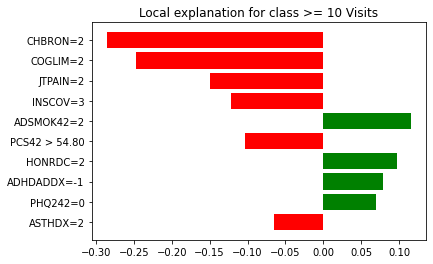

Predicted incorrectly by the model
Actual label: [1.]


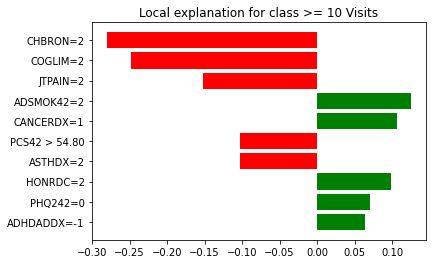

In [ ]:
print("Predicted correctly by the model")
show_explanation(correct_i)
print("Predicted incorrectly by the model")
show_explanation(wrong_pre_i)

On the above, we showcased two different predictions of the model, one of them being correctly predicted and the other one of them was wrongfully predicted.

Through the use LIME, we could see the most deterministic factor involved in the decision was CHBRON (EMPHYSEMA DIAGNOSIS) which led to the mistaken classification.

We believe that the LIME visualization helps us to understand how to fine-tune our model. In this case, we believe generating a related variable with both CHBRON and PCS4 would help.

In [ ]:
lr_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=lr_transf_panel19,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])

In [ ]:
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.3939
Best balanced accuracy: 0.7044
Corresponding 1-min(DI, 1/DI) value: 0.4077
Corresponding average odds difference value: -0.0252
Corresponding statistical parity difference value: -0.0861
Corresponding equal opportunity difference value: -0.0243
Corresponding Theil index value: 0.1143


The metrics above shows how the model perform on the basis of different metrics. This include:


*   Accuracy
*   Disparate impact ($1-min(DI, \frac{1}{DI})$)
*   Average odds difference
*   Statistical parity difference
*   Equal opportunity difference
*   Theil index 

Different metrics show different ways to interpret the model. Our team values accuracy and disparate impact the most. Valuing accuracy allows us to continue to build statistically better-performing models. Valuing disparate impact allows our team to find whether such accuracy would be at the cost of the protected group's interest. Other metrics shown above would, in some sense, convey the same message as disparate interest. Our team believes that it is the best because it is easy to explain and understand.


Although we could not use Lime to recreate the chart to detailly explains the different variables in our best model -- the pre-processed RandomForestClassifier model. Our team would want to explain it to see how much influence the feature to the final output.

In [ ]:
scaler = StandardScaler()
data_scaled_feat = scaler.fit_transform(dataset_transf_panel19_train.features)
model_nopip = RandomForestClassifier(n_estimators=500, min_samples_leaf=25)
rf_transf_panel19_nopipe = model_nopip.fit(data_scaled_feat, dataset_transf_panel19_train.labels.ravel(), sample_weight=dataset_transf_panel19_train.instance_weights)

In [ ]:
rf_transf_panel19_nopipe.predict(dataset_orig_panel19_test.features)

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
dataset_orig_panel19_test.labels.flatten()

array([0., 0., 1., ..., 0., 0., 1.])

Let's randomly pick a correct classification and incorrect classification and show how confident the model is with regarding the correct and incorrect classification.

In [ ]:
# Find which index has different value, randomly picked from the dataset
mod_pred = rf_transf_panel19_nopipe.predict(dataset_orig_panel19_test.features)
diff_index = np.where((dataset_orig_panel19_test.labels).flatten() != mod_pred)[0]
wrong_pre_i = np.random.choice(diff_index)
correct_i = diff_index[0]
while correct_i in diff_index:
  correct_i = np.random.choice(np.arange(0, len(mod_pred)))

Correct Classification:
The correct labeling is: 0.0


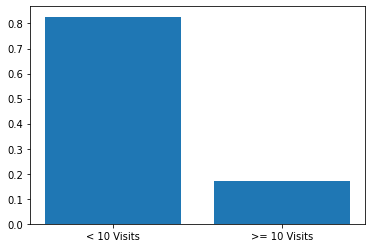

In [ ]:
print("Correct Classification:")
print("The correct labeling is: " + str((dataset_orig_panel19_test.labels).flatten()[correct_i]))

plt.bar(["< 10 Visits",">= 10 Visits"],rf_transf_panel19_nopipe.predict_proba([dataset.features[correct_i]])[0])
plt.show()

Incorrect Classification:
The correct labeling is: 1.0


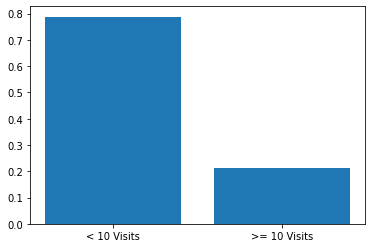

In [ ]:
print("Incorrect Classification:")
print("The correct labeling is: " + str((dataset_orig_panel19_test.labels).flatten()[wrong_pre_i]))

plt.bar(["< 10 Visits",">= 10 Visits"],rf_transf_panel19_nopipe.predict_proba([dataset.features[wrong_pre_i]])[0])
plt.show()

We could see from the 2 classification examples, we are able to see some of the features of some incorrect classification and some correct classifications. However, having some incorrect classification is good for the random forest model in general due to the fact that the model may have a tendency for overfitting.

### [8.](#Table-of-Contents) Conclusion & Discussion

During model development, we found that age and age-related variables had high feature importance. Optimizing the number of features or features used did not yield any meaningful improvements for our fairness metrics. We found that the random forest model using reject option classification had the best disparate impact metric and was above average for the other fairness metrics while performing with around the same balanced accuracy as other models. However, reject option classification, while good for group fairness, had issues with individual fairness since it purposefully provides favorable outcomes to unprivileged classes. Thus similar individuals may not necessarily be treated similarly. Because of this, if we needed to deploy this model in this setting, we would instead ultimately recommend the next best model we found in terms of our fairness metrics which is logistic regression with the reweighing preprocessing technique. This decision presents its own issues as its disparate impact value is 0.77, which shows that while bias was mitigated, there still exists positive classification bias towards our privileged class. As a positive classification means the patient would have high utilization, there is a significant cost in terms of false negative and false negative, which makes the lingering bias a concern.

### [9.](#Table-of-Contents) Contributions

1. Introduction- Qixi Huang, Joseph Perez, Maricela Vasquez 
2. EDA- Edwin Tse, Garrick Su
3. Initial Model Development- Qixi Huang
4. Additional Model Development- Joseph Perez
5. Bias Mitigation- Joseph Perez, Garrick Su, Maricela Vasquez
6. Results Summary- Joseph Perez
7. Explainability- Edwin Tse
8. Conclusion- Joseph Perez, Garrick Su